<a href="https://colab.research.google.com/github/aefif77/FYP_Project/blob/main/FYP_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INITIAL DATA PRE-PROCESSING**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow --quiet


In [ ]:
#Libraries
import numpy as np
import pandas as pd
from math import sqrt
import time

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
sns.set_context(context='paper',font_scale=1.5)
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from datetime import datetime, timedelta
from tqdm import tqdm

import itertools


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
wti_price = pd.read_csv('/content/drive/MyDrive/FYP PROJECT/DATASETS/WTI Crude Oil Price Dataset  - WTI Price Data (Dr. Marina).csv')
brent_price = pd.read_csv('/content/drive/MyDrive/FYP PROJECT/DATASETS/WTI Crude Oil Price Dataset  - BRENT Price Data (Dr.Marina).csv')

In [ ]:
pd.concat([wti_price.head(), wti_price.tail()]) #5433 instances

,Date,Price
0,04/15/2021,63.51
1,04/14/2021,63.22
2,04/13/2021,60.24
3,04/12/2021,59.75
4,04/09/2021,59.35
5429,01/10/2000,24.67
5430,01/07/2000,24.22
5431,01/06/2000,24.78
5432,01/05/2000,24.91
5433,01/04/2000,25.55


In [ ]:
wti_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5434 entries, 0 to 5433
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5434 non-null   object 
 1   Price   5434 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.0+ KB


In [ ]:
wti_price.isna().sum()

,0
Date,0
Price,0


In [ ]:
pd.concat([brent_price.head(), brent_price.tail()]) #5461 instances

,Date,Price
0,04/15/2021,66.94
1,04/14/2021,66.58
2,04/13/2021,63.67
3,04/12/2021,63.28
4,04/09/2021,62.95
5457,01/10/2000,23.73
5458,01/07/2000,23.09
5459,01/06/2000,23.62
5460,01/05/2000,23.73
5461,01/04/2000,24.39


In [ ]:
brent_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5462 entries, 0 to 5461
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5462 non-null   object 
 1   Price   5462 non-null   float64
dtypes: float64(1), object(1)
memory usage: 85.5+ KB


In [ ]:
brent_price.isna().sum()

,0
Date,0
Price,0


In [ ]:
# Convert the date to dateimte object
wti_price['Date'] = pd.to_datetime(wti_price['Date'], format='%m/%d/%Y')

print(wti_price['Date'].dtype)

datetime64[ns]


In [ ]:
wti_df = wti_price
wti_df

# Change the index of the Df as date index
# wti_df.index = pd.date_range(start='02-04-2014', end='02-05-2024', freq='D')
wti_df = wti_price.set_index('Date')
wti_df

,Price
Date,
2021-04-15,63.51
2021-04-14,63.22
2021-04-13,60.24
2021-04-12,59.75
2021-04-09,59.35
...,...
2000-01-10,24.67
2000-01-07,24.22
2000-01-06,24.78


In [ ]:
# Convert the date to dateimte object
brent_price['Date'] = pd.to_datetime(brent_price['Date'], format='%m/%d/%Y')

print(brent_price['Date'].dtype)

datetime64[ns]


In [ ]:
brent_df = brent_price
brent_df

# Change the index of the Df as date index
# wti_df.index = pd.date_range(start='02-04-2014', end='02-05-2024', freq='D')
brent_df = brent_price.set_index('Date')
brent_df

,Price
Date,
2021-04-15,66.94
2021-04-14,66.58
2021-04-13,63.67
2021-04-12,63.28
2021-04-09,62.95
...,...
2000-01-10,23.73
2000-01-07,23.09
2000-01-06,23.62


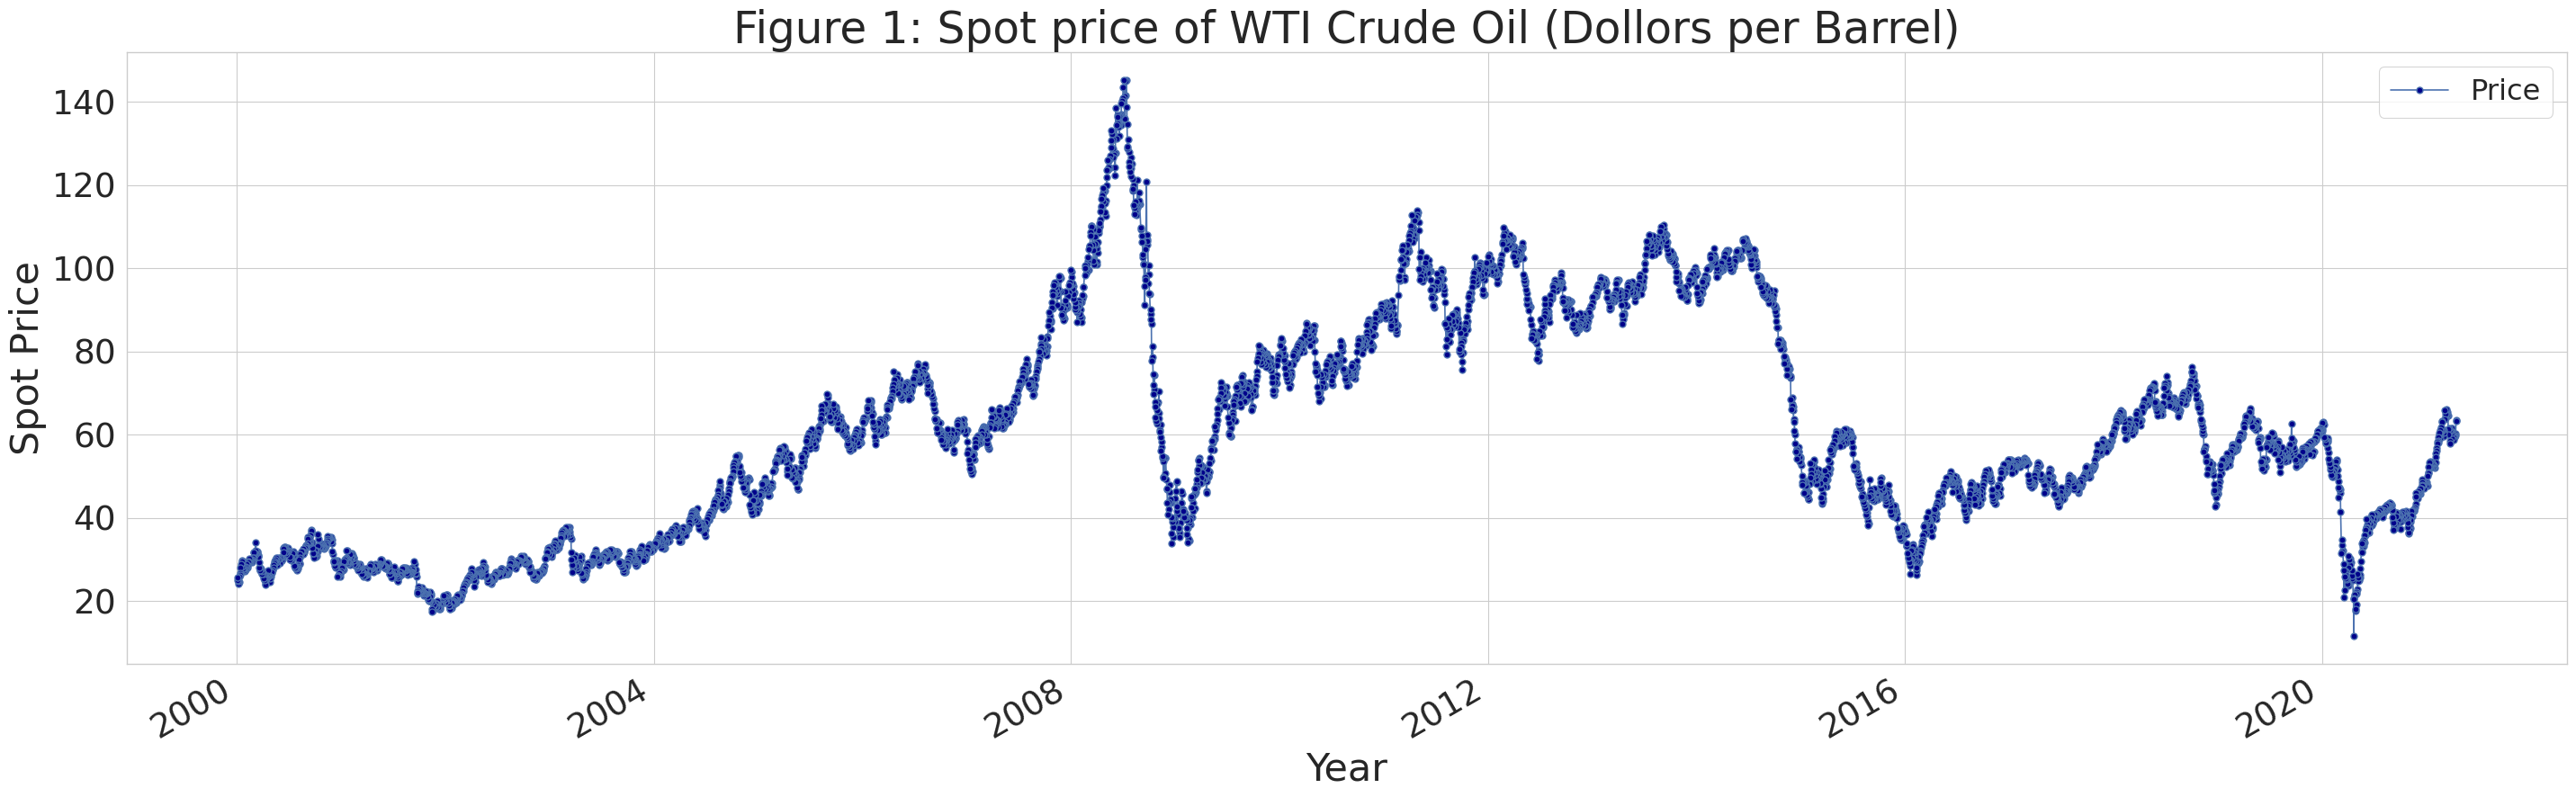

In [ ]:
# Time Series Plot of the WTI data
fig_1 = wti_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Figure 1: Spot price of WTI Crude Oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_WTI_ts.png')

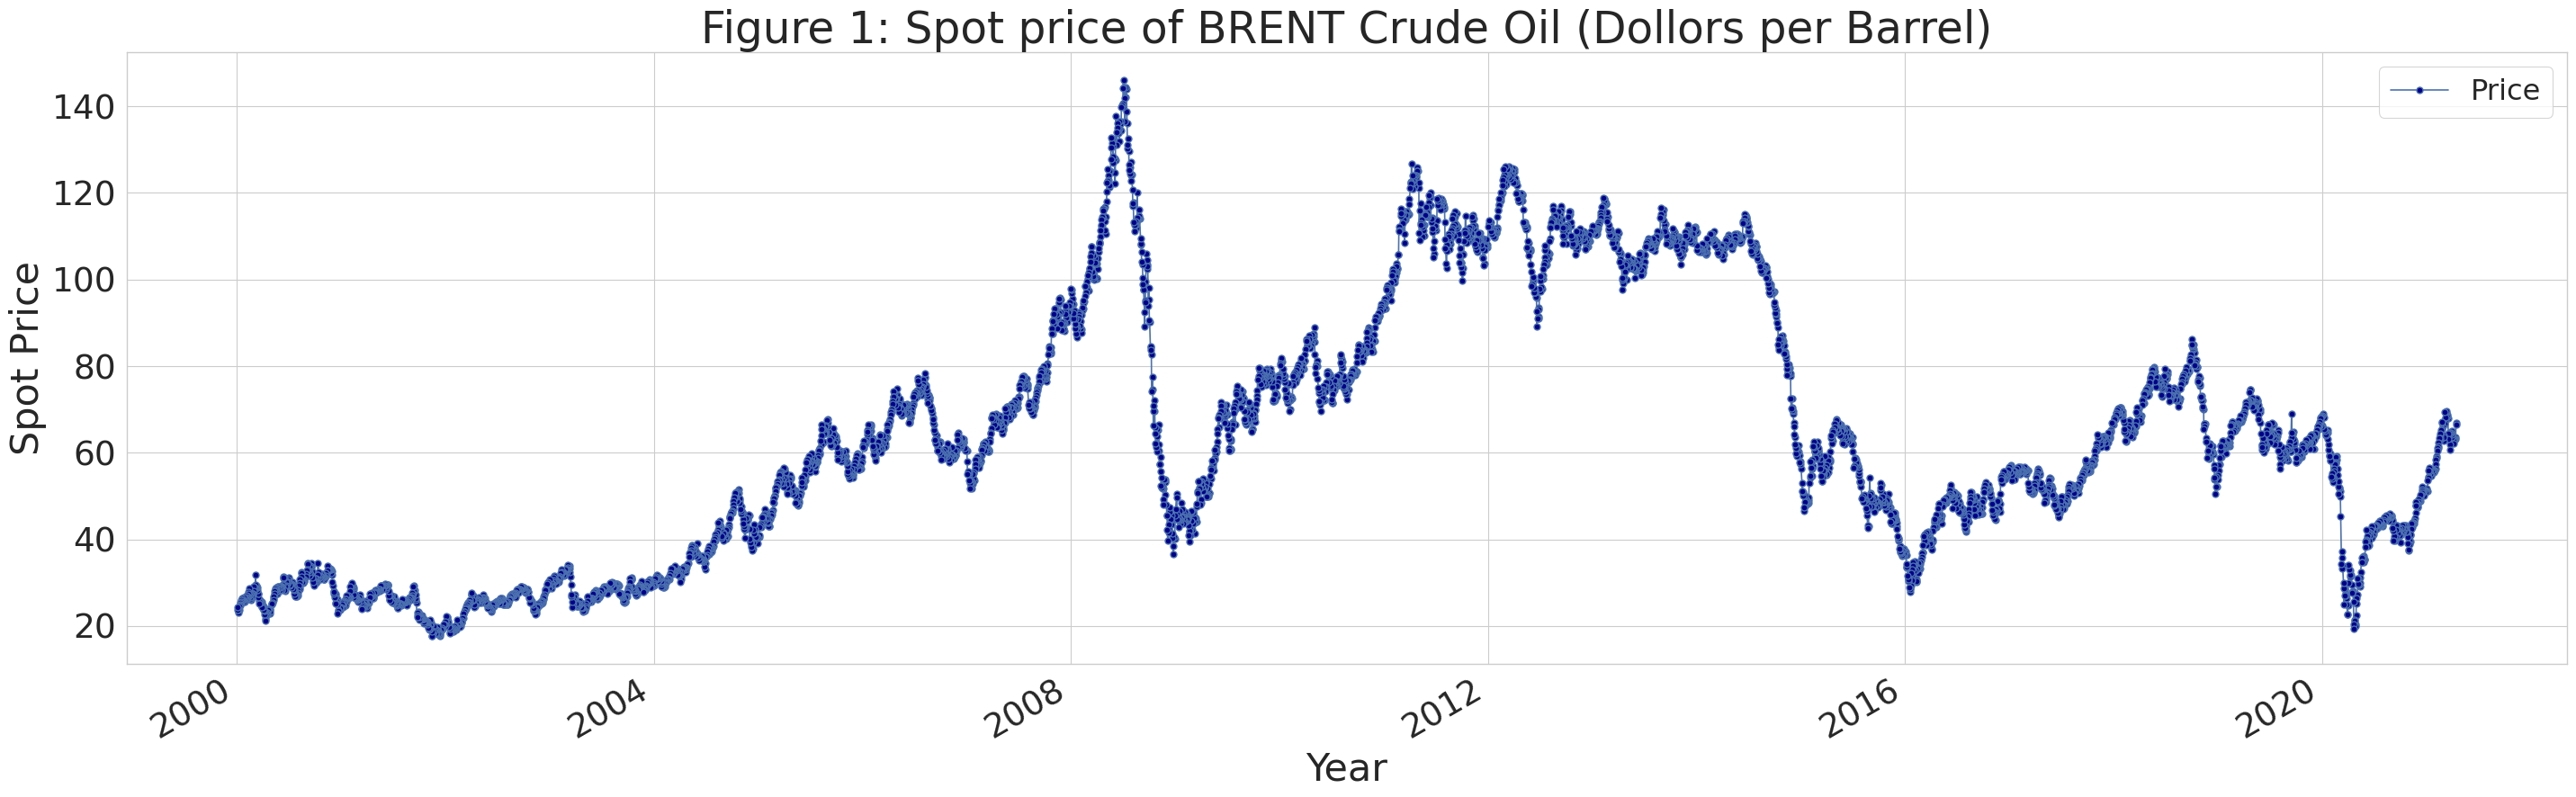

In [ ]:
# Time Series Plot of the Brent data
fig_5 = brent_df.squeeze().plot(figsize=(35,10),markersize=10, markerfacecolor= 'darkblue',marker='.',grid=True)
plt.legend(fontsize=23)
plt.title("Figure 1: Spot price of BRENT Crude Oil (Dollors per Barrel)",fontsize=35)
plt.xlabel("Year", fontsize=31)
plt.ylabel("Spot Price",fontsize=31)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.savefig('fig_1_BRENT_ts.png')

# **WTI CRUDE OIL PRICE FORECASTING**

WTI missing values:
 Price    0
dtype: int64 



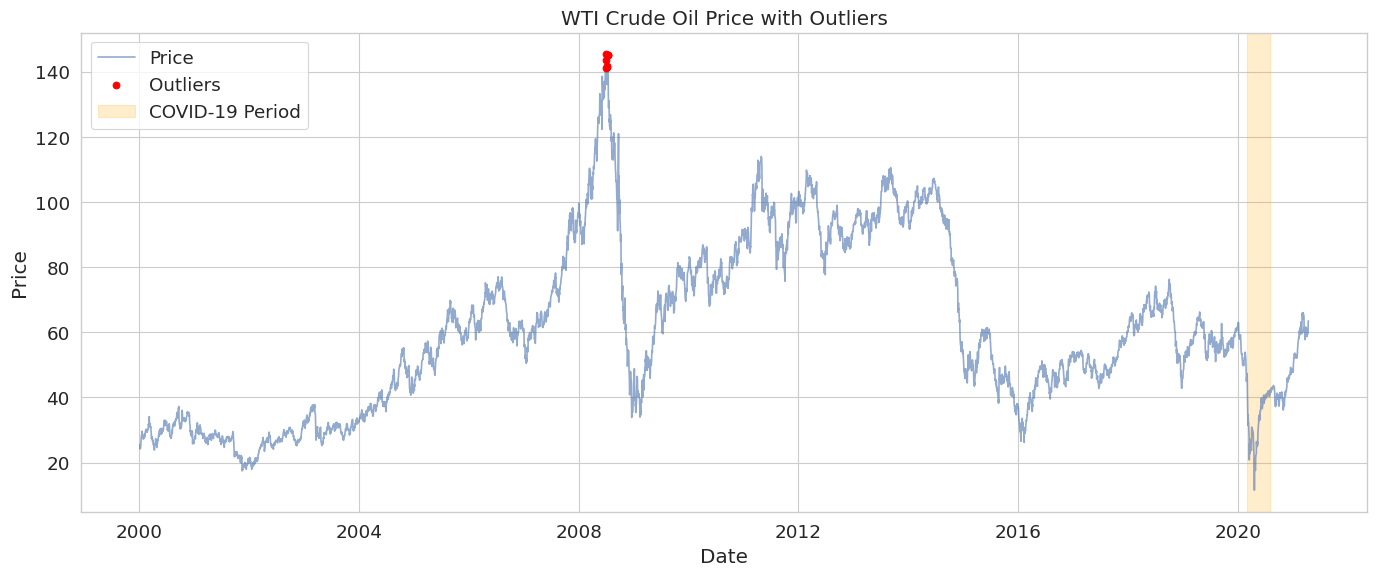

Dropped 7 non-COVID outliers. Final rows: 5427


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde


def show_missing(df, name):
    print(f"{name} missing values:\n", df.isna().sum(), "\n")

show_missing(wti_df, 'WTI')

def detect_iqr_outliers_visual(df, col='Price', mult=1.5,
                                covid_start='2020-03-01', covid_end='2020-07-31'):
    df = df.copy()

    # Ensure Date is the index and in datetime format
    df.index = pd.to_datetime(df.index)

    # Tag COVID-19 period
    df['is_covid'] = ((df.index >= pd.to_datetime(covid_start)) &
                      (df.index <= pd.to_datetime(covid_end))).astype(int)

    # Calculate IQR on non-COVID data
    non_covid_data = df[df['is_covid'] == 0]
    Q1, Q3 = non_covid_data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - mult * IQR, Q3 + mult * IQR

    # Flag non-COVID outliers
    df['is_outlier'] = ((df[col] < lower) | (df[col] > upper)) & (df['is_covid'] == 0)

    # Cleaned data
    df_cleaned = df[~df['is_outlier']].copy()

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[col], label='Price', alpha=0.6)
    plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']][col],
                color='red', label='Outliers', zorder=5)
    plt.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
                color='orange', alpha=0.2, label='COVID-19 Period')
    plt.title('WTI Crude Oil Price with Outliers')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Dropped {df['is_outlier'].sum()} non-COVID outliers. Final rows: {len(df_cleaned)}")
    return df_cleaned, df


wti_clean, wti_flagged = detect_iqr_outliers_visual(wti_df, col='Price')


--- Dataset Split Summary ---
Total samples: 5422
Train: 3254 (2000-01-04 → 2013-01-02)
Val:   1084 (2013-01-03 → 2017-02-23)
Test:  1084 (2017-02-24 → 2021-04-08)


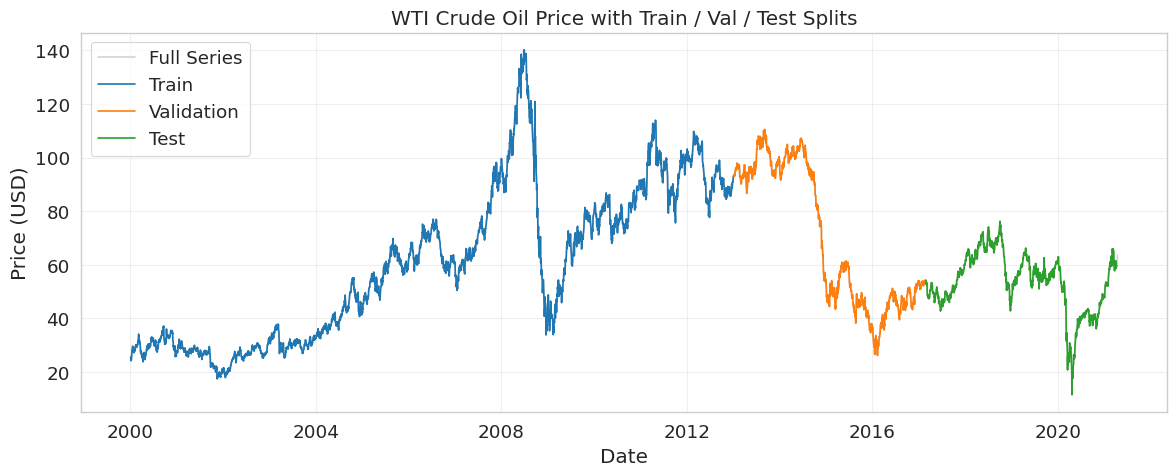

       Raw Mean  Raw StdDev  Scaled Mean  Scaled StdDev
lag_5    60.150      28.032         -0.0            1.0
lag_4    60.129      28.033          0.0            1.0
lag_3    60.108      28.034          0.0            1.0
lag_2    60.087      28.035          0.0            1.0
lag_1    60.066      28.036          0.0            1.0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm


def make_sliding_window_df(series, window_size):
    df = pd.DataFrame()
    for lag in range(window_size, 0, -1):
        df[f'lag_{lag}'] = series.shift(lag)
    df['target'] = series
    return df.dropna()

def normalize_and_split(dataframe, test_size=0.20, val_size=0.20, scale_target=False):
    dataframe = dataframe.sort_index()
    X = dataframe.drop('target', axis=1)
    y = dataframe['target']
    total_len = len(X)

    test_len = int(total_len * test_size)
    remaining = total_len - test_len
    val_len = int(remaining * (val_size / (1 - test_size)))
    train_len = total_len - test_len - val_len

    if train_len + val_len + test_len != total_len:
        train_len += total_len - (train_len + val_len + test_len)

    # split
    X_train = X.iloc[:train_len];   y_train = y.iloc[:train_len]
    X_val   = X.iloc[train_len:train_len+val_len]; y_val   = y.iloc[train_len:train_len+val_len]
    X_test  = X.iloc[train_len+val_len:];         y_test  = y.iloc[train_len+val_len:]

    # scale X
    scaler_X = StandardScaler()
    X_train_s = scaler_X.fit_transform(X_train)
    X_val_s   = scaler_X.transform(X_val)
    X_test_s  = scaler_X.transform(X_test)

    X_train_df = pd.DataFrame(X_train_s, index=X_train.index, columns=X_train.columns)
    X_val_df   = pd.DataFrame(X_val_s,   index=X_val.index,   columns=X_val.columns)
    X_test_df  = pd.DataFrame(X_test_s,  index=X_test.index,  columns=X_test.columns)

    # scale y
    if scale_target:
        scaler_y = StandardScaler()
        y_train_out = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
        y_val_out   = scaler_y.transform(y_val.values.reshape(-1,1)).flatten()
        y_test_out  = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()
    else:
        scaler_y    = None
        y_train_out = y_train
        y_val_out   = y_val
        y_test_out  = y_test

    print("\n--- Dataset Split Summary ---")
    print(f"Total samples: {total_len}")
    print(f"Train: {len(X_train_df)} ({X_train_df.index[0].date()} → {X_train_df.index[-1].date()})")
    print(f"Val:   {len(X_val_df)} ({X_val_df.index[0].date()} → {X_val_df.index[-1].date()})")
    print(f"Test:  {len(X_test_df)} ({X_test_df.index[0].date()} → {X_test_df.index[-1].date()})")

    return X_train_df, X_val_df, X_test_df, y_train_out, y_val_out, y_test_out, scaler_X, scaler_y

lookback = 5  # sliding window length

if 'wti_clean' not in locals() or 'Price' not in wti_clean.columns:
    raise ValueError("wti_clean DataFrame with 'Price' column is required.")

price_series = wti_clean['Price']


wti_feats2 = make_sliding_window_df(price_series, window_size=lookback)

X_train_scaled_df, X_val_scaled_df, X_test_scaled_df, \
y_train, y_val, y_test, scaler_X, scaler_y = normalize_and_split(
    wti_feats2,
    test_size=0.20,
    val_size=0.20,
    scale_target=False
)

# assume price_series, X_train_scaled_df, X_val_scaled_df, X_test_scaled_df already exist

plt.figure(figsize=(12,5))

# plot full series in light grey
plt.plot(wti_clean.index, price_series.values, color='lightgrey', label='Full Series')

# overlay train, val, test
plt.plot(price_series.loc[X_train_scaled_df.index].index,
         price_series.loc[X_train_scaled_df.index].values,
         color='tab:blue', label='Train')

plt.plot(price_series.loc[X_val_scaled_df.index].index,
         price_series.loc[X_val_scaled_df.index].values,
         color='tab:orange', label='Validation')

plt.plot(price_series.loc[X_test_scaled_df.index].index,
         price_series.loc[X_test_scaled_df.index].values,
         color='tab:green', label='Test')

plt.title('WTI Crude Oil Price with Train / Val / Test Splits')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

X_train_raw = pd.DataFrame(
    scaler_X.inverse_transform(X_train_scaled_df),
    index=X_train_scaled_df.index,
    columns=X_train_scaled_df.columns
)

raw_stats    = X_train_raw.agg(['mean', 'std']).T
scaled_stats = X_train_scaled_df.agg(['mean', 'std']).T

# 2. Combine into a single table
summary = pd.DataFrame({
    'Raw Mean':    raw_stats['mean'],
    'Raw StdDev':  raw_stats['std'],
    'Scaled Mean': scaled_stats['mean'],
    'Scaled StdDev': scaled_stats['std'],
})

# 3. (Optional) round for readability
summary = summary.round(3)

# 4. Display
print(summary)



In [ ]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4463 sha256=4e2252af12958997da689d4e113b886ca54bd64e11a2008884323040e05d4967
  Stored in directory: /root/.cache/pip/wheels/bb/4f/ec/8970b83323e16aa95034da175454843947376614d6d5e9627f
Successfully built pyswarm


Lower bounds (lb): [100, 0.001, 3, 8, 5, 0.5, 0.5, 0.0, 0.0]
Upper bounds (ub): [3000, 0.1, 32, 128, 50, 1.0, 1.0, 10.0, 10.0]

--- PSO Parameters ---
Swarm size: 50
Max iterations: 50
Inertia weight (omega): 0.8
Cognitive coefficient (phip/C1): 1.5
Social coefficient (phig/C2): 1.5
No constraints given.
New best parameters: n_estimators=2699, learning_rate=0.0357, max_depth=23, num_leaves=94, min_child_samples=12, subsample=0.96, colsample_bytree=0.77, reg_alpha=1.89, reg_lambda=2.53 → RMSE=1.6314
New best parameters: n_estimators=2909, learning_rate=0.0969, max_depth=22, num_leaves=79, min_child_samples=37, subsample=0.68, colsample_bytree=0.74, reg_alpha=5.06, reg_lambda=4.88 → RMSE=1.4780
New best parameters: n_estimators=2120, learning_rate=0.0524, max_depth=31, num_leaves=111, min_child_samples=5, subsample=0.60, colsample_bytree=0.96, reg_alpha=6.44, reg_lambda=2.71 → RMSE=1.4663
New best parameters: n_estimators=2536, learning_rate=0.0886, max_depth=21, num_leaves=38, min_child

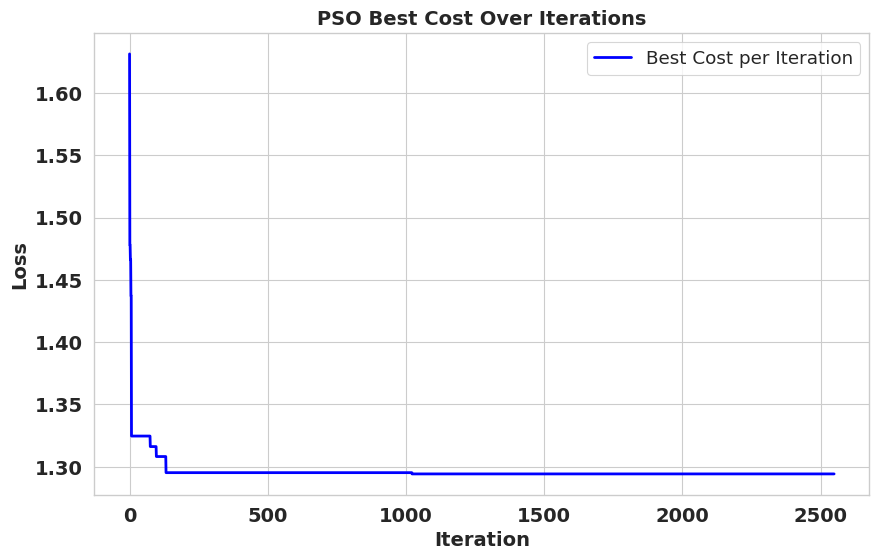


→ PSO-tuned hyperparameters (after adjustments):
  n_estimators: 100
  learning_rate: 0.0705293964532095
  max_depth: 3
  num_leaves: 58
  min_child_samples: 50
  subsample: 0.9443624405541845
  colsample_bytree: 1.0
  reg_alpha: 0.0
  reg_lambda: 0.0
  random_state: 42
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	training's rmse: 1.55164	training's l2: 2.40758	valid_1's rmse: 1.29415	valid_1's l2: 1.67482


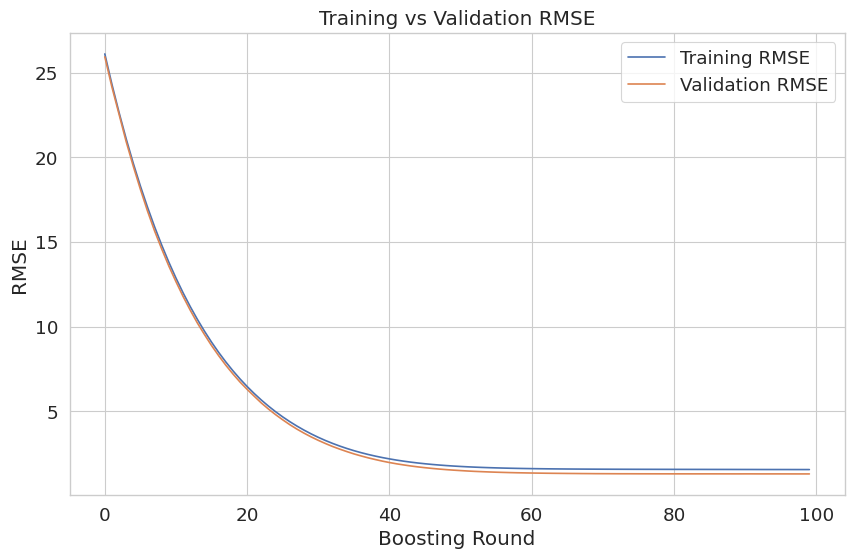


=== PSO-tuned LGBM Training Set Performance ===
RMSE: 1.5516
MAE : 1.0410

=== FINAL TEST PERFORMANCE (PSO-tuned LGBM) ===
RMSE: 1.2705
MAE : 0.9044


In [ ]:
# PSO-LGBM MODELLING CELL
from lightgbm import LGBMRegressor
from pyswarm import pso
from lightgbm import LGBMRegressor
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np


best_rmse = float('inf')
best_cost_history = []

def lgbm_objective(params):
    """
    PSO objective for LightGBM: returns validation RMSE,
    tracks best_rmse and best_cost_history, and prints when a new best is found.
    """
    global best_rmse, best_cost_history

    # Unpack your hyperparameters (order must match lb/ub in your PSO call)
    n_estimators, learning_rate, max_depth, num_leaves, \
    min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda = params

    # Build model
    model = LGBMRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        verbose=-1
    )

    # Train & validate
    model.fit(X_train_scaled_df, y_train)
    y_val_pred = model.predict(X_val_scaled_df)
    rmse = sqrt(mean_squared_error(y_val, y_val_pred))
    loss = rmse

    # Update convergence history: always store the running minimum loss
    if best_cost_history:
        best_cost_history.append(min(loss, best_cost_history[-1]))
    else:
        best_cost_history.append(loss)

    # If this is a new best, update and print
    if rmse < best_rmse:
        best_rmse = rmse
        print(
            f"New best parameters: "
            f"n_estimators={int(n_estimators)}, "
            f"learning_rate={learning_rate:.4f}, "
            f"max_depth={int(max_depth)}, "
            f"num_leaves={int(num_leaves)}, "
            f"min_child_samples={int(min_child_samples)}, "
            f"subsample={subsample:.2f}, "
            f"colsample_bytree={colsample_bytree:.2f}, "
            f"reg_alpha={reg_alpha:.2f}, "
            f"reg_lambda={reg_lambda:.2f} → RMSE={rmse:.4f}"
        )

    return loss

best_accuracy = 0

# Order: n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
lb = [100, 0.001, 3, 8, 5, 0.5, 0.5, 0.0, 0.0]
ub = [3000, 0.1, 32, 128, 50, 1.0, 1.0, 10.0, 10.0]

print("Lower bounds (lb):", lb)
print("Upper bounds (ub):", ub)

# Define PSO parameters
swarmsize = 50        # Number of particles in the swarm
maxiter = 50          # Maximum number of iterations
omega = 0.8          # Inertia weight [0,1] (default 0.8)
phip = 1.5            # Cognitive coefficient (C1) (default 1.5)
phig = 1.5            # Social coefficient (C2) (default 1.5)

print("\n--- PSO Parameters ---")
print(f"Swarm size: {swarmsize}")
print(f"Max iterations: {maxiter}")
print(f"Inertia weight (omega): {omega}")
print(f"Cognitive coefficient (phip/C1): {phip}")
print(f"Social coefficient (phig/C2): {phig}")


# Run PSO without the callback argument
best_hyperparameters, best_rmse = pso(
    func=lgbm_objective,
    lb=lb,
    ub=ub,
    swarmsize=swarmsize,
    maxiter=maxiter,
    omega=omega,          # Inertia weight
    phip=phip,            # Cognitive coefficient (C1)
    phig=phig,            # Social coefficient (C2)
    debug = True
)

# Print PSO results
print("\n--- PSO Results ---")
print("Best Hyperparameters found:", best_hyperparameters)
print("Best RMSE found:", best_rmse)

plt.figure(figsize=(10, 6))
plt.plot(best_cost_history, label='Best Cost per Iteration', color='blue', linewidth=2)  # Thicker curve
plt.title('PSO Best Cost Over Iterations', fontweight='bold', fontsize=14)  # Adjustable font size for the title
plt.xlabel('Iteration', fontweight='bold', fontsize=14)  # Bold and adjustable font size for X-axis
plt.ylabel('Loss', fontweight='bold', fontsize=14)  # Bold and adjustable font size for Y-axis
plt.xticks(fontweight='bold', fontsize=14)  # Bold and adjustable font size for X-axis ticks
plt.yticks(fontweight='bold', fontsize=14)  # Bold and adjustable font size for Y-axis ticks
plt.legend()
plt.grid(True)
plt.show()

# 7) Train final model on full train + early stopping on val set

# Correctly map PSO output to LGBM parameters and ensure correct types
final_model_params = {
    'n_estimators': int(round(best_hyperparameters[0])),
    'learning_rate': float(best_hyperparameters[1]),
    'max_depth': int(round(best_hyperparameters[2])),
    'num_leaves': int(round(best_hyperparameters[3])),
    'min_child_samples': int(round(best_hyperparameters[4])),
    'subsample': float(best_hyperparameters[5]),
    'colsample_bytree': float(best_hyperparameters[6]),
    'reg_alpha': float(best_hyperparameters[7]),
    'reg_lambda': float(best_hyperparameters[8]),
    'random_state': 42,
}

# Ensure num_leaves is at least 2
if final_model_params['num_leaves'] < 2:
    print(f"Warning: PSO suggested num_leaves={final_model_params['num_leaves']}. Setting to minimum required value of 2.")
    final_model_params['num_leaves'] = 2

# Ensure other integer parameters are valid if needed (e.g., >= 1)
if final_model_params['max_depth'] < 1 and final_model_params['max_depth'] != -1:
     print(f"Warning: PSO suggested max_depth={final_model_params['max_depth']}. Setting to 1.")
     final_model_params['max_depth'] = 1
if final_model_params['min_child_samples'] < 1:
    print(f"Warning: PSO suggested min_child_samples={final_model_params['min_child_samples']}. Setting to 1.")
    final_model_params['min_child_samples'] = 1
if final_model_params['n_estimators'] < 1:
    print(f"Warning: PSO suggested n_estimators={final_model_params['n_estimators']}. Setting to 1.")
    final_model_params['n_estimators'] = 1

fit_params = {}
if 'n_iter_no_change' in final_model_params:
    fit_params['n_iter_no_change'] = final_model_params.pop('n_iter_no_change')
if 'validation_fraction' in final_model_params:
     fit_params['validation_fraction'] = final_model_params.pop('validation_fraction')
if 'tol' in final_model_params:
     fit_params['tol'] = final_model_params.pop('tol')


print("\n→ PSO-tuned hyperparameters (after adjustments):")
for k, v in final_model_params.items():
    print(f"  {k}: {v}")

# Initialize LGBMRegressor with the adjusted parameters
final_model = LGBMRegressor(**final_model_params)

# Use the separate validation set for early stopping
final_callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=10),
]

# Train the model with early stopping on the validation set
final_model.fit(
    X_train_scaled_df, y_train,
    eval_set=[(X_train_scaled_df, y_train), (X_val_scaled_df, y_val)], # Include training set here
    eval_metric='rmse',
    callbacks=final_callbacks
)

# Plot training/validation RMSE
eval_results = final_model.evals_result_
plt.figure(figsize=(10, 6))
plt.plot(eval_results['training']['rmse'], label='Training RMSE')
plt.plot(eval_results['valid_1']['rmse'], label='Validation RMSE')
plt.title('Training vs Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# --- Evaluate on Training Set ---
y_train_pred = final_model.predict(
    X_train_scaled_df,
    num_iteration=final_model.best_iteration_
)
train_rmse = sqrt(mean_squared_error(y_train, y_train_pred))
train_mae  = mean_absolute_error(y_train, y_train_pred)
print("\n=== PSO-tuned LGBM Training Set Performance ===")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE : {train_mae:.4f}")

# 8) Predict & evaluate on test set
y_pred = final_model.predict(
    X_test_scaled_df,
    num_iteration=final_model.best_iteration_
)

test_rmse = sqrt(mean_squared_error(y_test, y_pred))
test_mae  = mean_absolute_error(y_test, y_pred)

print("\n=== FINAL TEST PERFORMANCE (PSO-tuned LGBM) ===")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")

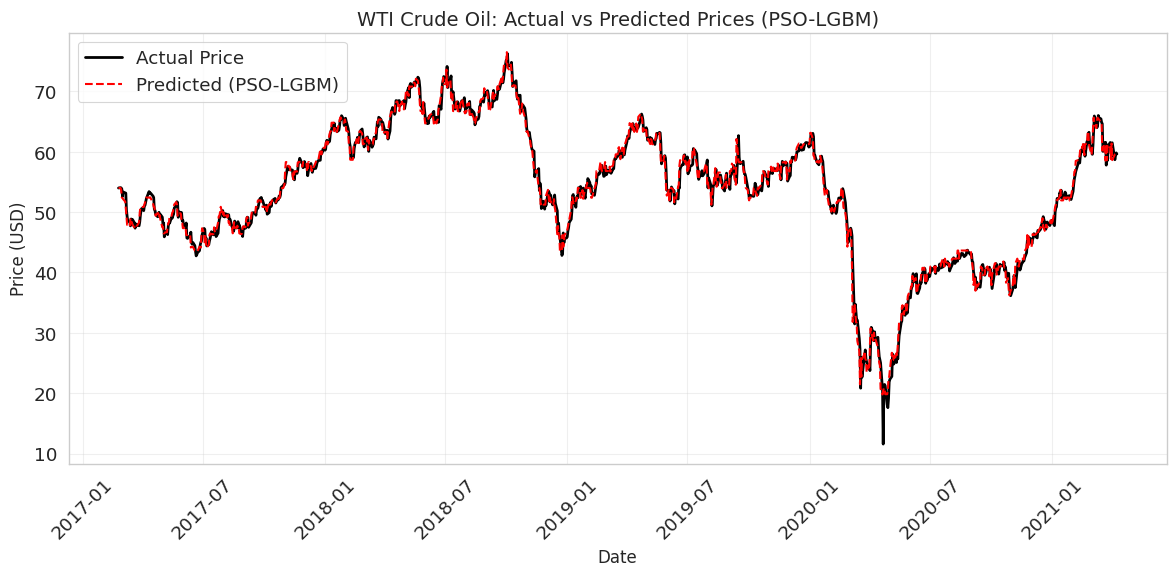


=== PSO-LGBM Test Set Performance ===
RMSE: 1.2705
MAE : 0.9044
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/WTI_PSOLGBM_DataPredictions.csv


,Actual_Price,Predicted_Price_LGBM
Date,,
2017-02-24,53.99,54.001712
2017-02-27,54.05,54.001712
2017-02-28,54.01,53.684151
2017-03-01,53.83,52.406973
2017-03-02,52.61,52.327674


In [ ]:
# =====================
# ACTUAL VS PREDICTED PLOT (PSO - LGBM)
# =====================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error # Import metrics for clarity

if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_test.index

y_pred = final_model.predict(X_test_scaled_df)

y_pred_array = np.asarray(y_pred)

plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (PSO-LGBM)', color='red', linestyle='--', linewidth=1.5)

plt.title('WTI Crude Oil: Actual vs Predicted Prices (PSO-LGBM)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== PSO-LGBM Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'y_pred' not in locals():
    raise ValueError("y_pred (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual_Price': y_test.values,
    'Predicted_Price_LGBM': y_pred
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_PSOLGBM_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

Default LGBM training took 0.1 seconds

=== Default LGBM Validation Performance ===
Lookback (lag features): 5
RMSE: 1.3868, MAE: 1.0838

=== Default LGBM Training Performance ===
Lookback (lag features): 5
RMSE: 1.2299, MAE: 0.8786

=== Default LGBM Test Performance ===
Lookback (lag features): 5
RMSE: 1.3068, MAE: 0.9439



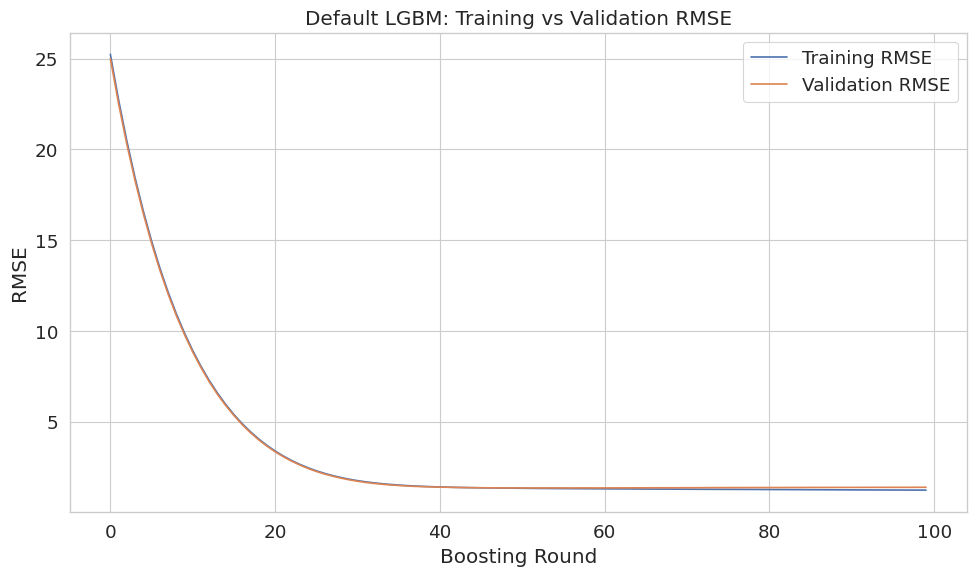

In [ ]:
import time
from lightgbm import LGBMRegressor
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Determine the number of lag features (lookback length)
lookback_lgbm = X_train_scaled_df.shape[1]


def run_lgbm_default(X_tr, y_tr, X_val, y_val, X_te, y_te):

    model = LGBMRegressor()

    # Measure training time with early stopping
    start = time.time()
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_tr, y_tr), (X_val, y_val)],
        eval_metric='rmse',
    )
    duration = time.time() - start
    print(f"Default LGBM training took {duration:.1f} seconds\n")

    # Validation evaluation
    y_val_pred = model.predict(X_val, num_iteration=model.best_iteration_)
    rmse_val = sqrt(mean_squared_error(y_val, y_val_pred))
    mae_val = mean_absolute_error(y_val, y_val_pred)
    print("=== Default LGBM Validation Performance ===")
    print(f"Lookback (lag features): {lookback_lgbm}")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}\n")

    y_train_pred = model.predict(X_train_scaled_df, num_iteration=model.best_iteration_)
    rmse_val = sqrt(mean_squared_error(y_train, y_train_pred))
    mae_val = mean_absolute_error(y_train, y_train_pred)
    print("=== Default LGBM Training Performance ===")
    print(f"Lookback (lag features): {lookback_lgbm}")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}\n")

    # Test evaluation
    y_test_pred = model.predict(X_te, num_iteration=model.best_iteration_)
    rmse_test = sqrt(mean_squared_error(y_te, y_test_pred))
    mae_test = mean_absolute_error(y_te, y_test_pred)
    print("=== Default LGBM Test Performance ===")
    print(f"Lookback (lag features): {lookback_lgbm}")
    print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}\n")

    return model, y_val_pred, y_test_pred

lgbm_model_default, y_val_pred_lgbm, y_test_pred_lgbm = run_lgbm_default(
    X_train_scaled_df, y_train,
    X_val_scaled_df, y_val,
    X_test_scaled_df, y_test
)

evals = lgbm_model_default.evals_result_

plt.figure(figsize=(10, 6))
plt.plot(evals['training']['rmse'], label='Training RMSE')
plt.plot(evals['valid_1']['rmse'], label='Validation RMSE')
plt.title('Default LGBM: Training vs Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'y_pred' not in locals():
    raise ValueError("y_pred (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Actual_Price': y_test.values,
    'Predicted_Price_LGBM': y_pred
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_PSOLGBM_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

In [ ]:
#AdaBoost Modelling with RandomizedSearchCV for Comparison

from sklearn.tree import DecisionTreeRegressor
lookback_ada = X_train_scaled_df.shape[1]
param_dist_ada = {
    'n_estimators': [100],
    'learning_rate': [0.05],
    'estimator__max_depth': [15]
}

tscv_ada = TimeSeriesSplit(n_splits=5)

base_est = DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base_est, random_state=42)

search_ada = RandomizedSearchCV(
    estimator           = ada,
    param_distributions = param_dist_ada,
    n_iter              = 50,
    cv                  = tscv_ada,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 2
)

def run_ada_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_ada.fit(X_tr, y_tr)
    print(f"AdaBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_ada = search_ada.best_estimator_

    # Evaluate on Validation Set
    val_preds = best_ada.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== AdaBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")


    # Evaluate on Test Set
    test_preds    = best_ada.predict(X_te)
    rmse_test = sqrt(mean_squared_error(y_te, test_preds))
    mae_test  = mean_absolute_error(y_te, test_preds)

    print(f"Number of lags (lookback): {lookback_ada}")
    print("=== AdaBoost Test Set Performance ===")
    print(f"RMSE: {rmse_test:.4f}, MAE: {mae_test:.4f}")
    print("Best AdaBoost parameters:", search_ada.best_params_,"\n")

    return search_ada, best_ada, val_preds, test_preds

ada_rand, best_ada, y_val_pred_ada, y_test_pred_ada   = run_ada_tscv(
    X_train_scaled_df, y_train,
    X_val_scaled_df, y_val,
    X_test_scaled_df, y_test
)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
AdaBoost RandomizedSearchCV took 9.9s

=== AdaBoost Validation Set Performance ===
RMSE: 1.4959, MAE: 1.1745
Number of lags (lookback): 5
=== AdaBoost Test Set Performance ===
RMSE: 1.3773, MAE: 1.0012
Best AdaBoost parameters: {'n_estimators': 100, 'learning_rate': 0.05, 'estimator__max_depth': 15} 



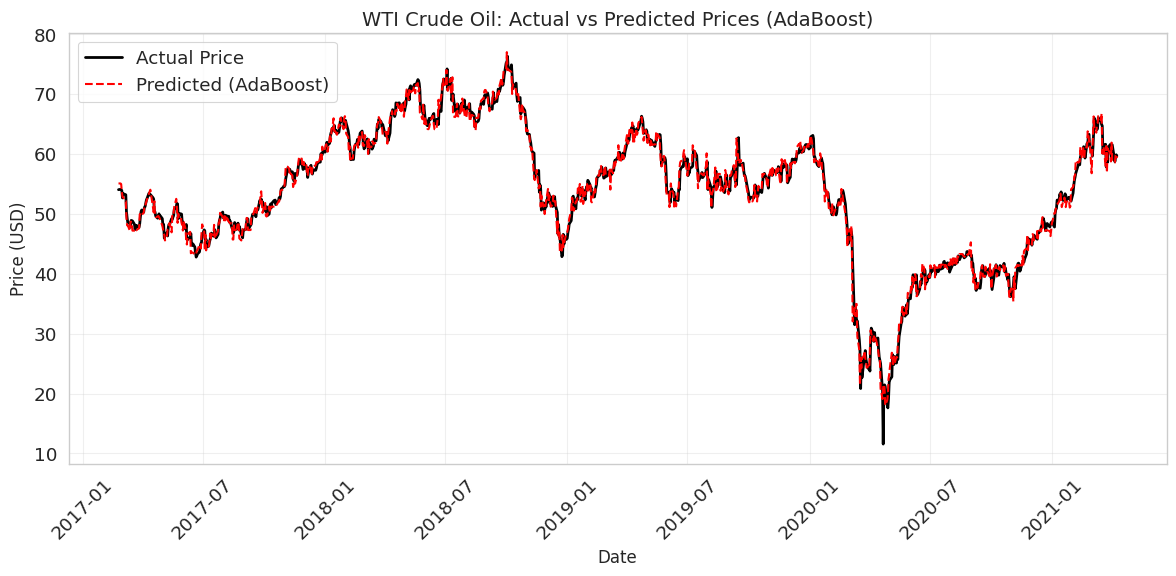


=== LGBM Test Set Performance ===
RMSE: 1.3773
MAE : 1.0012
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/WTI_AdaBoost_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-02-24,55.03
2017-02-27,55.03
2017-02-28,54.93
2017-03-01,53.71
2017-03-02,52.77


In [ ]:
# =====================
# ACTUAL VS PREDICTED PLOT (AdaBoost)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_test.index

preds = best_ada.predict(X_test_scaled_df)

y_pred_array = np.asarray(preds)


plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (AdaBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('WTI Crude Oil: Actual vs Predicted Prices (AdaBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== LGBM Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_AdaBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


CatBoost RandomizedSearchCV took 466.6s

=== CatBoost Validation Set Performance ===
RMSE: 1.5265, MAE: 1.1944
Number of lags (lookback): 5
=== CatBoost Test Set Performance ===
RMSE: 1.6100, MAE: 1.1672
Best CatBoost parameters: {'learning_rate': 0.05, 'iterations': 100, 'depth': 15} 



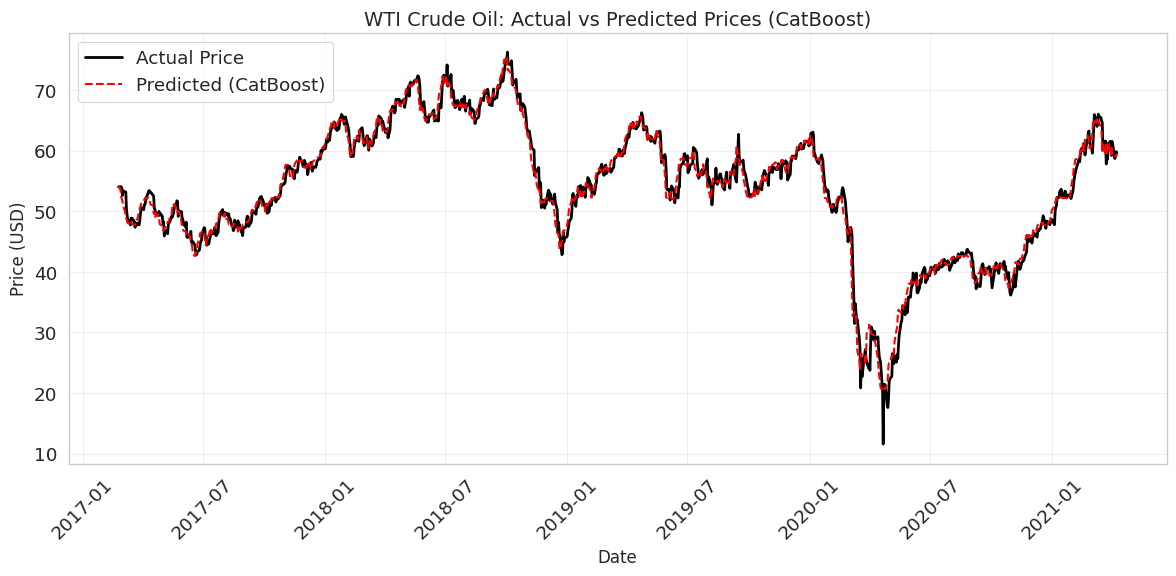


=== CatBoost Test Set Performance ===
RMSE: 1.6100
MAE : 1.1672
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/WTI_CatBoost_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-02-24,54.238817
2017-02-27,53.454963
2017-02-28,52.312428
2017-03-01,52.047045
2017-03-02,51.587093


In [ ]:
from catboost import CatBoostRegressor

# 5) CatBoost Modelling with RandomizedSearchCV for Comparison

lookback_cat = X_train_scaled_df.shape[1]
param_dist_cat = {
    'iterations': [100],
    'depth':      [15],
    'learning_rate': [0.05],
}

tscv_cat = TimeSeriesSplit(n_splits=5)
cat_base = CatBoostRegressor(verbose=0, random_state=42)

search_cat = RandomizedSearchCV(
    estimator           = cat_base,
    param_distributions = param_dist_cat,
    n_iter              = 50,
    cv                  = tscv_cat,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_cat_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_cat.fit(X_tr, y_tr)
    print(f"CatBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_cat = search_cat.best_estimator_

    # Evaluate on Validation Set
    val_preds = best_cat.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== CatBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

    # Evaluate on Test Set
    preds    = best_cat.predict(X_te)
    rmse_cat = sqrt(mean_squared_error(y_te, preds))
    mae_cat  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_cat}")
    print("=== CatBoost Test Set Performance ===")
    print(f"RMSE: {rmse_cat:.4f}, MAE: {mae_cat:.4f}")
    print("Best CatBoost parameters:", search_cat.best_params_,"\n")

    return search_cat, best_cat, val_preds

cat_rand, best_cat, y_val_pred_cat   = run_cat_tscv(X_train_scaled_df, y_train, X_val_scaled_df, y_val, X_test_scaled_df, y_test)

# =====================
# ACTUAL VS PREDICTED PLOT (CatBoost)
# =====================

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_test.index

preds = best_cat.predict(X_test_scaled_df)

y_pred_array = np.asarray(preds)

plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (CatBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('WTI Crude Oil: Actual vs Predicted Prices (CatBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== CatBoost Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_CatBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=50. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


XGBoost RandomizedSearchCV took 10.4s

=== XGBoost Validation Set Performance ===
RMSE: 1.5432, MAE: 1.2027
Number of lags (lookback): 5
=== XGBoost Test Set Performance ===
RMSE: 1.4639, MAE: 1.0882
Best XGBoost parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.05} 



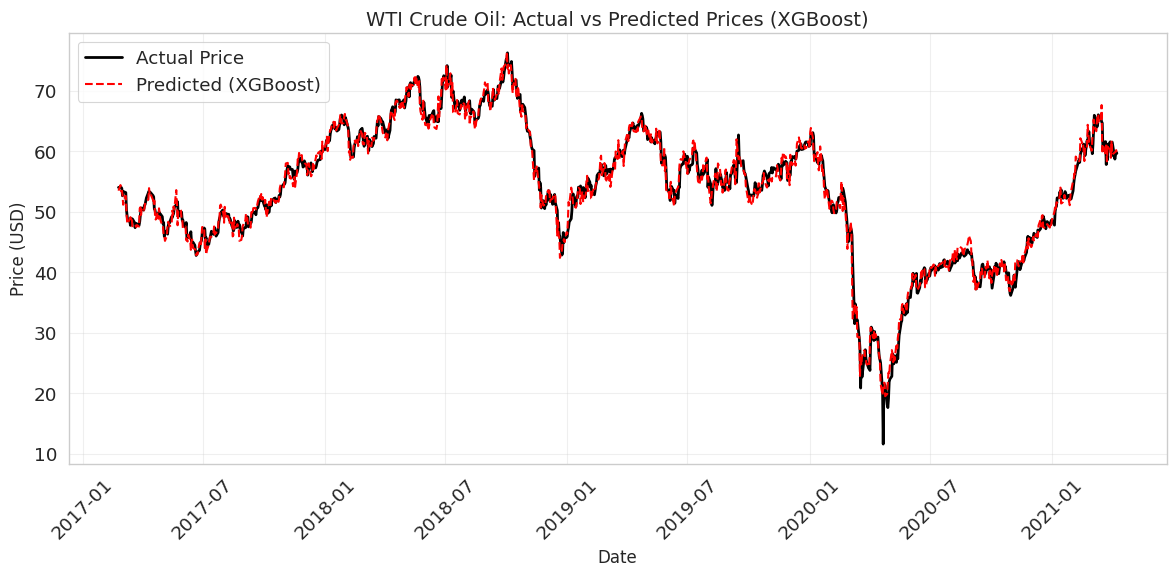


=== XGBoost Test Set Performance ===
RMSE: 1.4639
MAE : 1.0882
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/WTI_XGBoost_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-02-24,53.456238
2017-02-27,54.385029
2017-02-28,53.378952
2017-03-01,53.447136
2017-03-02,52.876846


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 6) XGBoost Modelling with RandomizedSearchCV for Comparison

lookback_xgb = X_train_scaled_df.shape[1]
param_dist_xgb = {
    'n_estimators': [100],
    'max_depth': [15],
    'learning_rate': [0.05],
}


tscv_xgb = TimeSeriesSplit(n_splits=5)
xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

search_xgb = RandomizedSearchCV(
    estimator           = xgb_base,
    param_distributions = param_dist_xgb,
    n_iter              = 50,
    cv                  = tscv_xgb,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_xgb_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_xgb.fit(X_tr, y_tr)
    print(f"XGBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_xgb = search_xgb.best_estimator_

    # Evaluate on Validation Set
    val_preds = best_xgb.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== XGBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")


    preds    = best_xgb.predict(X_te)
    rmse_xgb = sqrt(mean_squared_error(y_te, preds))
    mae_xgb  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_xgb}")
    print("=== XGBoost Test Set Performance ===")
    print(f"RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}")
    print("Best XGBoost parameters:", search_xgb.best_params_,"\n")

    return search_xgb, best_xgb, val_preds

xgb_rand, best_xgb, y_val_pred_xgb   = run_xgb_tscv(X_train_scaled_df, y_train, X_val_scaled_df, y_val, X_test_scaled_df, y_test)

# =====================
# ACTUAL VS PREDICTED PLOT (XGBoost)
# =====================

if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_test.index

preds = best_xgb.predict(X_test_scaled_df)

y_pred_array = np.asarray(preds)

plot_df = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted': y_pred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (XGBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('WTI Crude Oil: Actual vs Predicted Prices (XGBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== XGBoost Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_test, y_pred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_test, y_pred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_XGBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

# **BRENT CRUDE PRICE FORECASTING**

BRENT missing values:
 Price    0
dtype: int64 



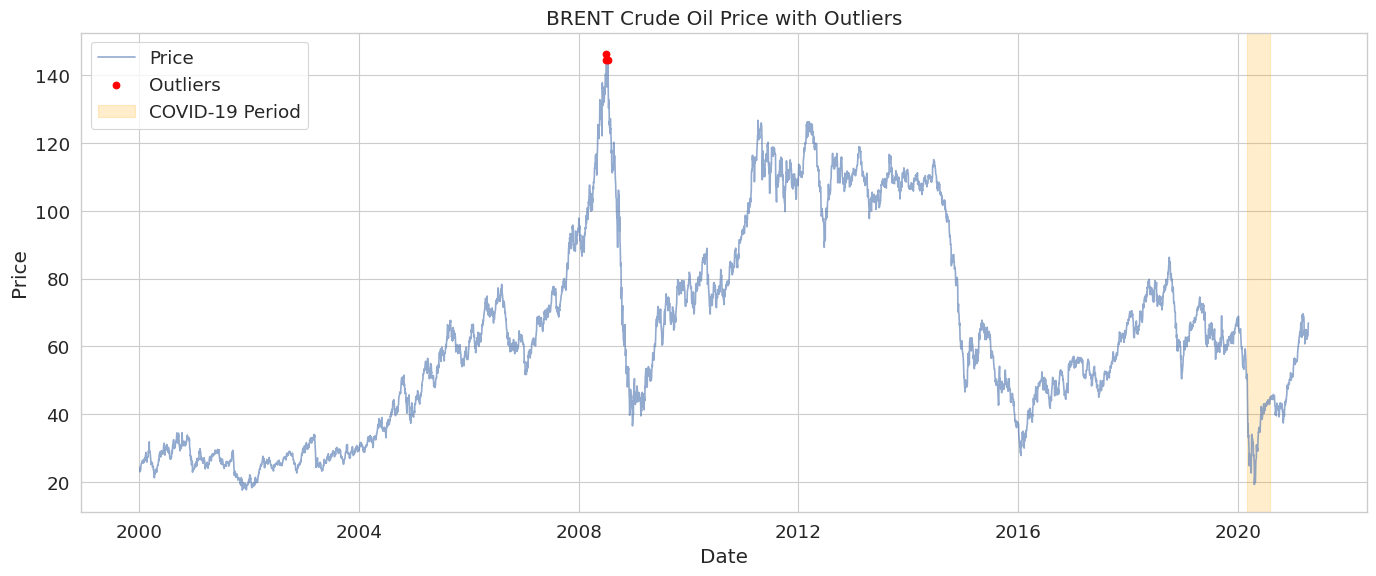

Dropped 3 non-COVID outliers. Final rows: 5459


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def show_missing(df, name):
    print(f"{name} missing values:\n", df.isna().sum(), "\n")

show_missing(brent_df, 'BRENT')

def detect_iqr_outliers_visual(df, col='Price', mult=1.5,
                                covid_start='2020-03-01', covid_end='2020-07-31'):
    df = df.copy()

    # Ensure Date is the index and in datetime format
    df.index = pd.to_datetime(df.index)

    # Tag COVID-19 period
    df['is_covid'] = ((df.index >= pd.to_datetime(covid_start)) &
                      (df.index <= pd.to_datetime(covid_end))).astype(int)

    # Calculate IQR on non-COVID data
    non_covid_data = df[df['is_covid'] == 0]
    Q1, Q3 = non_covid_data[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - mult * IQR, Q3 + mult * IQR

    # Flag non-COVID outliers
    df['is_outlier'] = ((df[col] < lower) | (df[col] > upper)) & (df['is_covid'] == 0)

    # Cleaned data
    df_cleaned = df[~df['is_outlier']].copy()

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df[col], label='Price', alpha=0.6)
    plt.scatter(df[df['is_outlier']].index, df[df['is_outlier']][col],
                color='red', label='Outliers', zorder=5)
    plt.axvspan(pd.to_datetime(covid_start), pd.to_datetime(covid_end),
                color='orange', alpha=0.2, label='COVID-19 Period')
    plt.title('BRENT Crude Oil Price with Outliers')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Dropped {df['is_outlier'].sum()} non-COVID outliers. Final rows: {len(df_cleaned)}")
    return df_cleaned, df

brent_clean, brent_flagged = detect_iqr_outliers_visual(brent_df, col='Price')


--- Lagged Feature Dataset Preview ---

--- Dataset Split Summary ---
Total samples in lagged data: 5454
Training samples: 3273 | Dates: 2000-01-04 → 2012-10-24
Validation samples: 1091 | Dates: 2012-10-25 → 2017-01-16
Test samples: 1090 | Dates: 2017-01-17 → 2021-04-08


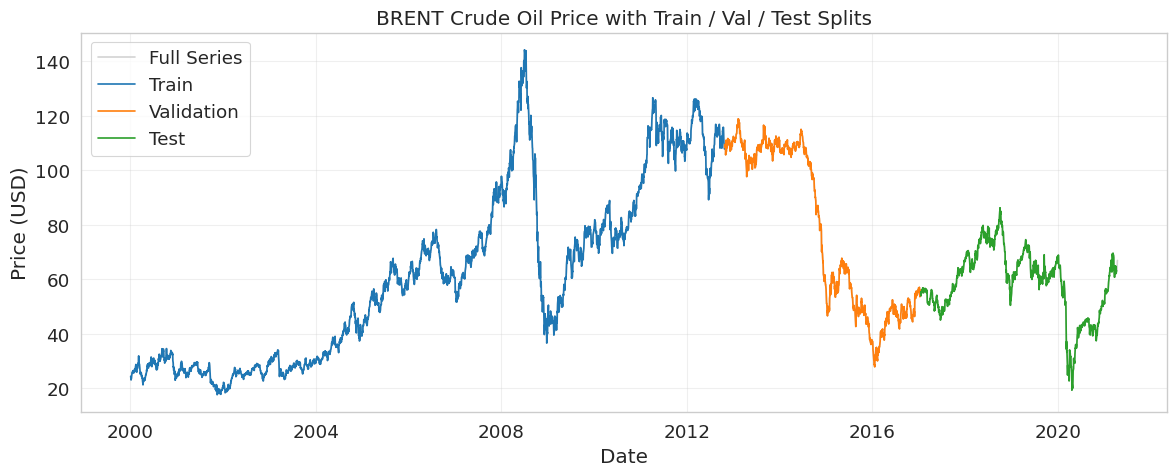

       Raw Mean  Raw StdDev  Scaled Mean  Scaled StdDev
lag_5    60.150      28.032          0.0            1.0
lag_4    60.129      28.033         -0.0            1.0
lag_3    60.108      28.034         -0.0            1.0
lag_2    60.087      28.035         -0.0            1.0
lag_1    60.066      28.036         -0.0            1.0


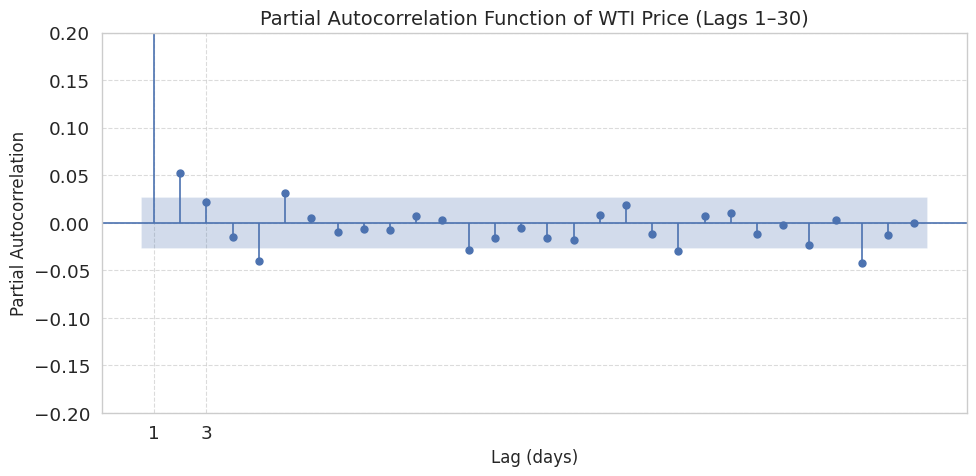

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

def make_sliding_window_df(series, window_size):
    """
    Creates a sliding window DataFrame from a single time series.

    Args:
        series (pd.Series): The input time series (should be a pandas Series).
        window_size (int): The number of previous time steps to use as features.

    Returns:
        pd.DataFrame: DataFrame with lagged features and the target.
    """
    df = pd.DataFrame()
    for lag in range(window_size, 0, -1):
        df[f'lag_{lag}'] = series.shift(lag)
    df['target'] = series
    return df.dropna()

def normalize_and_split(dataframe, test_size=0.20, val_size=0.20, scale_target=False):

    dataframe = dataframe.sort_index()

    X = dataframe.drop('target', axis=1)
    y = dataframe['target']

    total_len = len(X)
    test_len = int(total_len * test_size)
    remaining_len = total_len - test_len
    val_len = int(remaining_len * (val_size / (1 - test_size)))
    train_len = total_len - test_len - val_len

    current_sum = train_len + val_len + test_len
    if current_sum != total_len:
        train_len += (total_len - current_sum)


    # Split: [train | val | test]
    X_train = X.iloc[:train_len]
    y_train = y.iloc[:train_len]

    X_val = X.iloc[train_len:train_len + val_len]
    y_val = y.iloc[train_len:train_len + val_len]

    X_test = X.iloc[train_len + val_len:]
    y_test = y.iloc[train_len + val_len:]

    # Normalize features
    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_val_scaled = scaler_X.transform(X_val)
    X_test_scaled = scaler_X.transform(X_test)

    X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_val_scaled_df = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
    X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)


    if scale_target:
        scaler_y = StandardScaler()
        y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
        y_val_scaled = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
        y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
        y_train_out, y_val_out, y_test_out = y_train_scaled, y_val_scaled, y_test_scaled
    else:
        scaler_y = None
        y_train_out, y_val_out, y_test_out = y_train, y_val, y_test

    print("\n--- Lagged Feature Dataset Preview ---")
    if 'brent_feats' in locals():
         print(brent_feats.head())


    print("\n--- Dataset Split Summary ---")
    print(f"Total samples in lagged data: {total_len}")
    print(f"Training samples: {len(X_train_scaled_df)} | Dates: {X_train_scaled_df.index[0].date()} → {X_train_scaled_df.index[-1].date()}")
    print(f"Validation samples: {len(X_val_scaled_df)} | Dates: {X_val_scaled_df.index[0].date()} → {X_val_scaled_df.index[-1].date()}")
    print(f"Test samples: {len(X_test_scaled_df)} | Dates: {X_test_scaled_df.index[0].date()} → {X_test_scaled_df.index[-1].date()}")

    return (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df,
            y_train_out, y_val_out, y_test_out,
            scaler_X, scaler_y)

lookback = 5 # sliding window length


if 'brent_clean' in locals() and isinstance(brent_clean, pd.DataFrame) and 'Price' in brent_clean.columns:
     brent_price_series = brent_clean['Price']
else:
     raise ValueError("brent_clean DataFrame with 'Price' column is required.")


brent_feats = make_sliding_window_df(brent_price_series, window_size=lookback)


X_train_scaled_bdf, X_val_scaled_bdf, X_test_scaled_bdf, y_btrain, y_bval, y_btest, scaler_bX, scaler_by = normalize_and_split(
    brent_feats,
    test_size=0.20,
    val_size=0.20,
    scale_target=False
)

plt.figure(figsize=(12,5))

# plot full series in light grey
plt.plot(brent_clean.index, brent_price_series.values, color='lightgrey', label='Full Series')

# overlay train, val, test
plt.plot(brent_price_series.loc[X_train_scaled_bdf.index].index,
         brent_price_series.loc[X_train_scaled_bdf.index].values,
         color='tab:blue', label='Train')

plt.plot(brent_price_series.loc[X_val_scaled_bdf.index].index,
         brent_price_series.loc[X_val_scaled_bdf.index].values,
         color='tab:orange', label='Validation')

plt.plot(brent_price_series.loc[X_test_scaled_bdf.index].index,
         brent_price_series.loc[X_test_scaled_bdf.index].values,
         color='tab:green', label='Test')

plt.title('BRENT Crude Oil Price with Train / Val / Test Splits')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

X_train_braw = pd.DataFrame(
    scaler_X.inverse_transform(X_train_scaled_bdf),
    index=X_train_scaled_bdf.index,
    columns=X_train_scaled_bdf.columns
)

raw_stats_b    = X_train_braw.agg(['mean', 'std']).T
scaled_stats_b = X_train_scaled_bdf.agg(['mean', 'std']).T

# 2. Combine into a single table
summary = pd.DataFrame({
    'Raw Mean':    raw_stats_b['mean'],
    'Raw StdDev':  raw_stats_b['std'],
    'Scaled Mean': scaled_stats_b['mean'],
    'Scaled StdDev': scaled_stats_b['std'],
})

# 3. (Optional) round for readability
summary = summary.round(3)

# 4. Display
print(summary)

fig, ax = plt.subplots(figsize=(10, 5))

# Plot PACF on the given axes
plot_pacf(
    price_series,
    lags=30,
    alpha=0.05,
    zero=False,
    method='ywm',
    ax=ax
)

# Zoom in on the relevant range
ax.set_ylim(-0.2, 0.2)
# Show every 2nd lag for readability
ax.set_xticks(range(1, 5, 2))

# Enhance titles and labels
ax.set_title('Partial Autocorrelation Function of WTI Price (Lags 1–30)', fontsize=14)
ax.set_xlabel('Lag (days)', fontsize=12)
ax.set_ylabel('Partial Autocorrelation', fontsize=12)

# Add grid lines
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

lgbm_objective function defined.
Lower bounds (lb): [100, 0.001, 3, 8, 5, 0.5, 0.5, 0.0, 0.0]
Upper bounds (ub): [3000, 0.1, 20, 256, 50, 1.0, 1.0, 10.0, 10.0]

--- PSO Parameters ---
Swarm size: 50
Max iterations: 50
Inertia weight (omega): 0.8
Cognitive coefficient (phip/C1): 1.5
Social coefficient (phig/C2): 1.5
Stopping search: maximum iterations reached --> 50


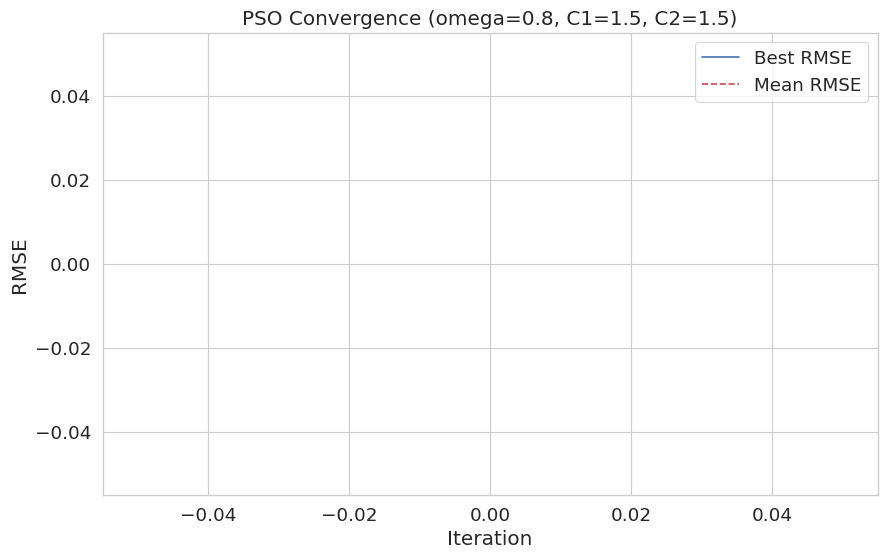


--- PSO Results ---
Best Hyperparameters found: [1.00000000e+02 5.77821301e-02 3.00000000e+00 1.73796979e+02
 5.00000000e+01 5.10916735e-01 1.00000000e+00 1.00000000e+01
 0.00000000e+00]
Best RMSE found: 1.3441198414700795

→ PSO-tuned hyperparameters (after adjustments):
  n_estimators: 100
  learning_rate: 0.05778213005812553
  max_depth: 3
  num_leaves: 174
  min_child_samples: 50
  subsample: 0.5109167351265501
  colsample_bytree: 1.0
  reg_alpha: 10.0
  reg_lambda: 0.0
  random_state: 42
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 1.34412	valid_0's l2: 1.80666

=== PSO-tuned LGBM Training Set Performance ===
RMSE: 1.4325
MAE : 0.9680

=== FINAL TEST PERFORMANCE (PSO-tuned LGBM) ===
RMSE: 2.1893
MAE : 1.7269


In [ ]:
# PSO-LGBM MODELLING CELL
from lightgbm import LGBMRegressor
from pyswarm import pso
from lightgbm import LGBMRegressor
import lightgbm as lgb
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

def lgbm_objective(hyperparameters):
    # Extract hyperparameters (ensure the order matches the bounds defined later for PSO)
    n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda = hyperparameters

    # Instantiate LGBMRegressor with the given hyperparameters
    # Convert integer hyperparameters to int type
    model = LGBMRegressor(
        n_estimators=int(n_estimators),
        learning_rate=learning_rate,
        max_depth=int(max_depth),
        num_leaves=int(num_leaves),
        min_child_samples=int(min_child_samples),
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=42,
        verbose=-1
    )

    # Train the model on the training data
    model.fit(X_train_scaled_bdf, y_btrain)

    # Make predictions on the validation data
    y_val_bpred = model.predict(X_val_scaled_bdf)

    # Calculate RMSE
    rmse = sqrt(mean_squared_error(y_bval, y_val_bpred))

    return rmse

print("lgbm_objective function defined.")

# Order: n_estimators, learning_rate, max_depth, num_leaves, min_child_samples, subsample, colsample_bytree, reg_alpha, reg_lambda
lb = [100, 0.001, 3, 8, 5, 0.5, 0.5, 0.0, 0.0]
ub = [3000, 0.1, 20, 256, 50, 1.0, 1.0, 10.0, 10.0]

print("Lower bounds (lb):", lb)
print("Upper bounds (ub):", ub)

# Define PSO parameters
swarmsize = 50        # Number of particles in the swarm
maxiter = 50          # Maximum number of iterations
omega = 0.8          # Inertia weight [0,1] (default 0.8)
phip = 1.5            # Cognitive coefficient (C1) (default 1.5)
phig = 1.5            # Social coefficient (C2) (default 1.5)

print("\n--- PSO Parameters ---")
print(f"Swarm size: {swarmsize}")
print(f"Max iterations: {maxiter}")
print(f"Inertia weight (omega): {omega}")
print(f"Cognitive coefficient (phip/C1): {phip}")
print(f"Social coefficient (phig/C2): {phig}")

# Initialize variables to track PSO convergence
pso_history = {'best_cost': [], 'mean_cost': []}

def pso_callback(swarm, swarm_cost):
    """Callback function to track PSO convergence"""
    pso_history['best_cost'].append(np.min(swarm_cost))
    pso_history['mean_cost'].append(np.mean(swarm_cost))
    return False  # Return False to continue optimization

# Run PSO with additional parameters
best_hyperparameters, best_rmse = pso(
    func=lgbm_objective,
    lb=lb,
    ub=ub,
    swarmsize=swarmsize,
    maxiter=maxiter,
    omega=omega,          # Inertia weight
    phip=phip,            # Cognitive coefficient (C1)
    phig=phig,            # Social coefficient (C2)
)

# Plot PSO Convergence
plt.figure(figsize=(10, 6))
plt.plot(pso_history['best_cost'], 'b-', label='Best RMSE')
plt.plot(pso_history['mean_cost'], 'r--', label='Mean RMSE')
plt.title('PSO Convergence (omega={}, C1={}, C2={})'.format(omega, phip, phig))
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

# Print results
print("\n--- PSO Results ---")
print("Best Hyperparameters found:", best_hyperparameters)
print("Best RMSE found:", best_rmse)

# 7) Train final model on full train + early stopping on val set

# Correctly map PSO output to LGBM parameters and ensure correct types
final_model_params = {
    'n_estimators': int(round(best_hyperparameters[0])),
    'learning_rate': float(best_hyperparameters[1]),
    'max_depth': int(round(best_hyperparameters[2])),
    'num_leaves': int(round(best_hyperparameters[3])),
    'min_child_samples': int(round(best_hyperparameters[4])),
    'subsample': float(best_hyperparameters[5]),
    'colsample_bytree': float(best_hyperparameters[6]),
    'reg_alpha': float(best_hyperparameters[7]),
    'reg_lambda': float(best_hyperparameters[8]),
    'random_state': 42,
}

# Ensure num_leaves is at least 2
if final_model_params['num_leaves'] < 2:
    print(f"Warning: PSO suggested num_leaves={final_model_params['num_leaves']}. Setting to minimum required value of 2.")
    final_model_params['num_leaves'] = 2

# Ensure other integer parameters are valid if needed (e.g., >= 1)
if final_model_params['max_depth'] < 1 and final_model_params['max_depth'] != -1:
     print(f"Warning: PSO suggested max_depth={final_model_params['max_depth']}. Setting to 1.")
     final_model_params['max_depth'] = 1
if final_model_params['min_child_samples'] < 1:
    print(f"Warning: PSO suggested min_child_samples={final_model_params['min_child_samples']}. Setting to 1.")
    final_model_params['min_child_samples'] = 1
if final_model_params['n_estimators'] < 1:
    print(f"Warning: PSO suggested n_estimators={final_model_params['n_estimators']}. Setting to 1.")
    final_model_params['n_estimators'] = 1

fit_params = {}
if 'n_iter_no_change' in final_model_params:
    fit_params['n_iter_no_change'] = final_model_params.pop('n_iter_no_change')
if 'validation_fraction' in final_model_params:
     fit_params['validation_fraction'] = final_model_params.pop('validation_fraction')
if 'tol' in final_model_params:
     fit_params['tol'] = final_model_params.pop('tol')

print("\n→ PSO-tuned hyperparameters (after adjustments):")
for k, v in final_model_params.items():
    print(f"  {k}: {v}")

# Initialize LGBMRegressor with the adjusted parameters
final_model = LGBMRegressor(**final_model_params)

# Use the separate validation set for early stopping
final_callbacks = [
    lgb.early_stopping(stopping_rounds=50, verbose=10),
]

# Train the model with early stopping on the validation set
final_model.fit(
    X_train_scaled_bdf, y_btrain,
    eval_set=[(X_val_scaled_bdf, y_bval)],
    eval_metric='rmse',
    callbacks=final_callbacks
)

# --- Evaluate on Training Set ---
y_train_bpred = final_model.predict(
    X_train_scaled_bdf,
    num_iteration=final_model.best_iteration_
)
train_rmse = sqrt(mean_squared_error(y_btrain, y_train_bpred))
train_mae  = mean_absolute_error(y_btrain, y_train_bpred)
print("\n=== PSO-tuned LGBM Training Set Performance ===")
print(f"RMSE: {train_rmse:.4f}")
print(f"MAE : {train_mae:.4f}")

# 8) Predict & evaluate on test set
y_pred = final_model.predict(
    X_test_scaled_bdf,
    num_iteration=final_model.best_iteration_
)

test_rmse = sqrt(mean_squared_error(y_btest, y_bpred))
test_mae  = mean_absolute_error(y_btest, y_bpred)

print("\n=== FINAL TEST PERFORMANCE (PSO-tuned LGBM) ===")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE : {test_mae:.4f}")

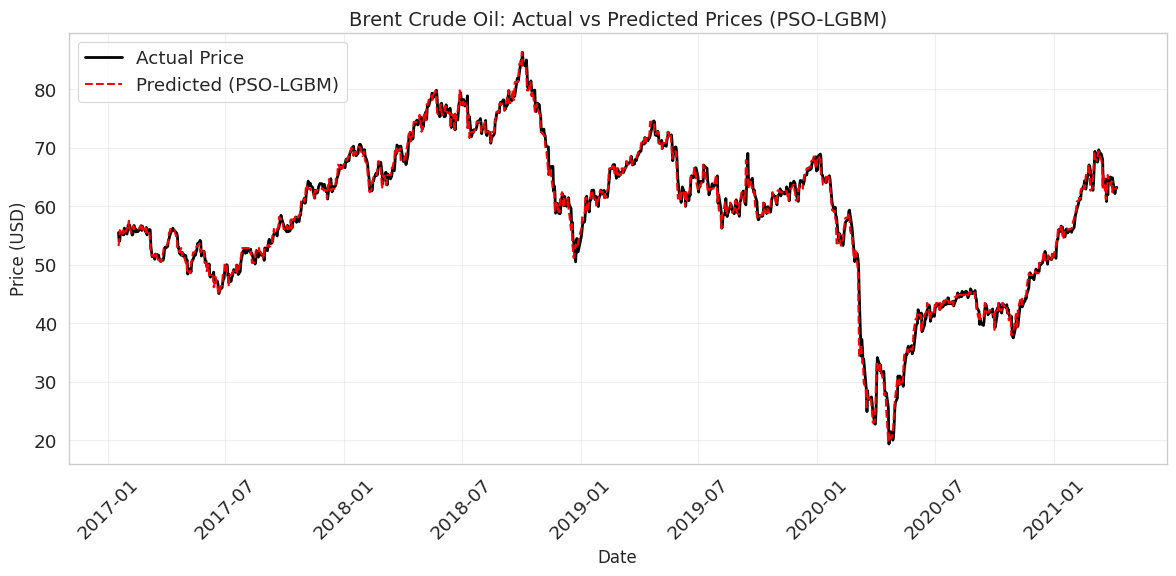


=== LGBM Test Set Performance ===
RMSE: 1.3280
MAE : 0.9355
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/BRENT_PSOLGBM_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-01-17,53.180072
2017-01-18,54.152594
2017-01-19,55.893932
2017-01-20,55.467552
2017-01-23,55.893932


In [ ]:
# =====================
# ACTUAL VS PREDICTED PLOT (LGBM)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error

if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_bdf' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_bdf for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_btest.index

y_bpred = final_model.predict(X_test_scaled_bdf)

y_bpred_array = np.asarray(y_bpred)

plot_df = pd.DataFrame({
    'Actual': y_btest.values,
    'Predicted': y_bpred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (PSO-LGBM)', color='red', linestyle='--', linewidth=1.5)

plt.title('Brent Crude Oil: Actual vs Predicted Prices (PSO-LGBM)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== LGBM Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_btest, y_bpred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_btest, y_bpred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Cannot create plot_bdf.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_btest.index

# Ensure y_pred is available as a numpy array or list
if 'y_bpred' not in locals():
    raise ValueError("y_bpred (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_bdf = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': y_bpred
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_bdf = results_bdf.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/BRENT_PSOLGBM_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_bdf.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_bdf.head())

Fitting 5 folds for each of 1 candidates, totalling 5 fits
AdaBoost RandomizedSearchCV took 6.9s

=== AdaBoost Validation Set Performance ===
RMSE: 2.4703, MAE: 2.0702
Number of lags (lookback): 5
=== AdaBoost Test Set Performance ===
RMSE: 1.9857, MAE: 1.5280
Best AdaBoost parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'estimator__max_depth': 3} 



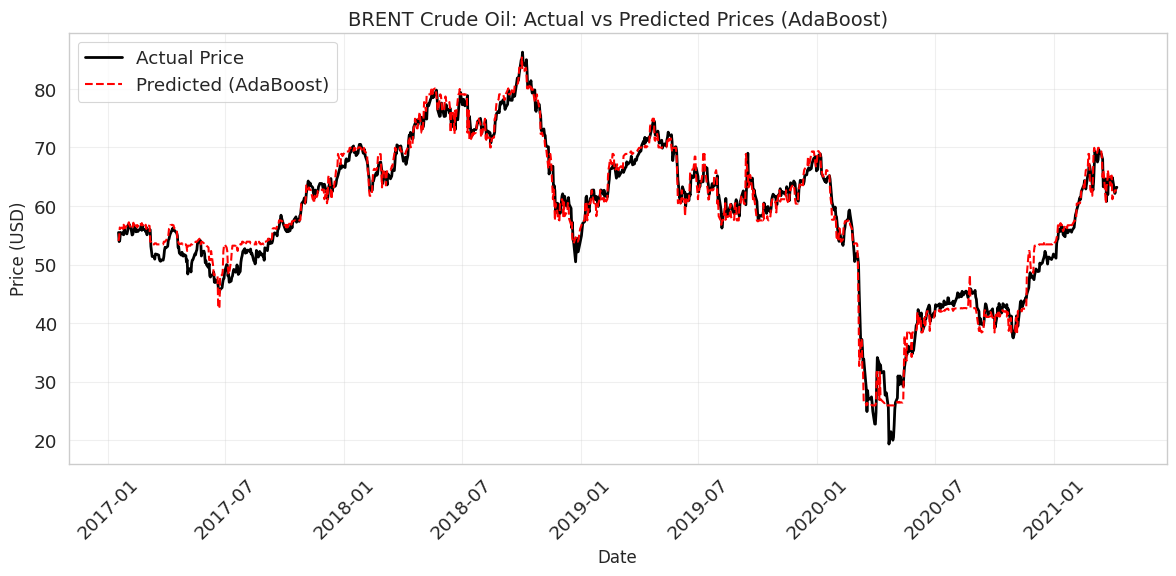


=== AdaBoost Test Set Performance ===
RMSE: 1.9857
MAE : 1.5280
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/BRENT_AdaBoost_DataPredictions.csv


,Actual_Price_LGBM,Predicted_Price_LGBM
Date,,
2017-01-17,55.47,54.029930
2017-01-18,53.92,54.617000
2017-01-19,54.16,56.337188
2017-01-20,55.49,56.204044
2017-01-23,55.23,56.337188


In [ ]:
from sklearn.tree import DecisionTreeRegressor

# 4) AdaBoost Modelling with RandomizedSearchCV for Comparison

lookback_ada = X_train_scaled_bdf.shape[1]
param_dist_ada = {
    'n_estimators': [100],
    'learning_rate': [0.1],
    'estimator__max_depth': [3]
}

tscv_ada = TimeSeriesSplit(n_splits=5)
base_est = DecisionTreeRegressor(random_state=42)
ada = AdaBoostRegressor(estimator=base_est, random_state=42)

search_ada = RandomizedSearchCV(
    estimator           = ada,
    param_distributions = param_dist_ada,
    n_iter              = 30,
    cv                  = tscv_ada,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_ada_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_ada.fit(X_tr, y_tr)
    print(f"AdaBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_ada = search_ada.best_estimator_

    val_preds = best_ada.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== AdaBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

    preds    = best_ada.predict(X_te)
    rmse_ada = sqrt(mean_squared_error(y_te, preds))
    mae_ada  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_ada}")
    print("=== AdaBoost Test Set Performance ===")
    print(f"RMSE: {rmse_ada:.4f}, MAE: {mae_ada:.4f}")
    print("Best AdaBoost parameters:", search_ada.best_params_,"\n")

    return search_ada, best_ada, val_preds

ada_rand, best_ada, y_val_pred_ada   = run_ada_tscv(X_train_scaled_bdf, y_btrain, X_val_scaled_bdf, y_bval, X_test_scaled_bdf, y_btest)

# =====================
# ACTUAL VS PREDICTED PLOT (AdaBoost)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error

if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_bdf' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_bdf for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_btest.index

preds = best_ada.predict(X_test_scaled_bdf)

y_bpred_array = np.asarray(preds)

plot_df = pd.DataFrame({
    'Actual': y_btest.values,
    'Predicted': y_bpred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (AdaBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('BRENT Crude Oil: Actual vs Predicted Prices (AdaBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== AdaBoost Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_btest, y_bpred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_btest, y_bpred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Cannot create plot_bdf.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_btest.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_bdf = pd.DataFrame({
    'Date': test_index,
    'Actual_Price_LGBM': y_btest.values,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_bdf = results_bdf.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/BRENT_AdaBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_bdf.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_bdf.head())

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
CatBoost RandomizedSearchCV took 1.7s

=== CatBoost Validation Set Performance ===
RMSE: 2.0767, MAE: 1.6155
Number of lags (lookback): 5
=== CatBoost Test Set Performance ===
RMSE: 2.0338, MAE: 1.5085
Best CatBoost parameters: {'learning_rate': 0.1, 'iterations': 100, 'depth': 3} 



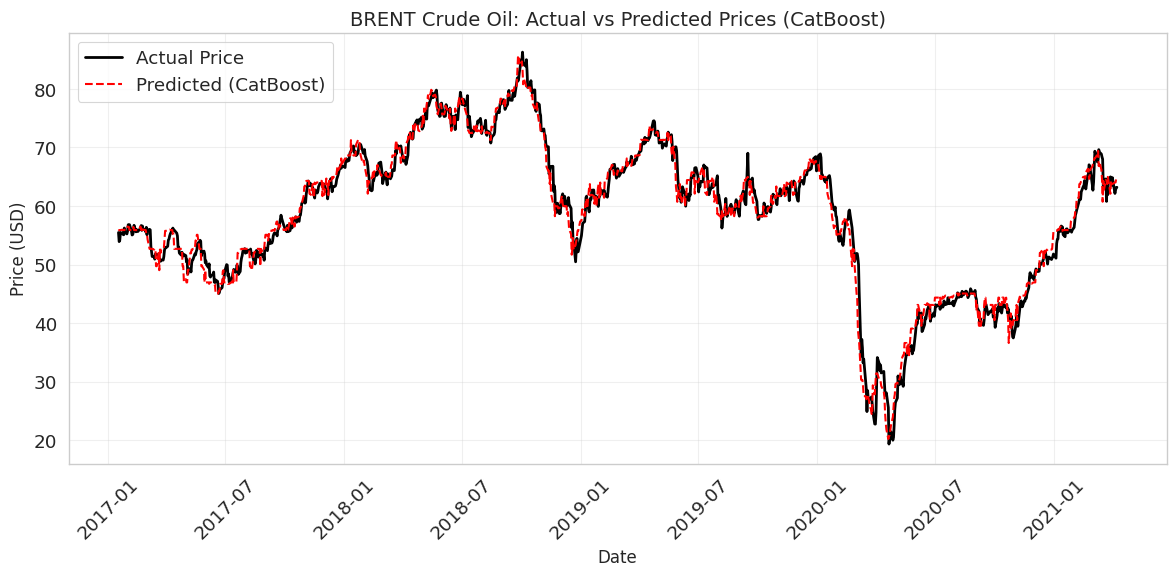


=== CatBoost Test Set Performance ===
RMSE: 2.0338
MAE : 1.5085
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/BRENT_CatBoost_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-01-17,55.756818
2017-01-18,55.889261
2017-01-19,55.889261
2017-01-20,55.889261
2017-01-23,55.958904


In [ ]:
# 5) CatBoost Modelling with RandomizedSearchCV for Comparison

lookback_cat = X_train_scaled_bdf.shape[1]
param_dist_cat = {
    'iterations': [100],
    'depth':      [3],
    'learning_rate': [0.1],
}

tscv_cat = TimeSeriesSplit(n_splits=5)
cat_base = CatBoostRegressor(verbose=0, random_state=42)

search_cat = RandomizedSearchCV(
    estimator           = cat_base,
    param_distributions = param_dist_cat,
    n_iter              = 30,
    cv                  = tscv_cat,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_cat_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_cat.fit(X_tr, y_tr)
    print(f"CatBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_cat = search_cat.best_estimator_

    val_preds = best_cat.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== CatBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

    preds    = best_cat.predict(X_te)
    rmse_cat = sqrt(mean_squared_error(y_te, preds))
    mae_cat  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_cat}")
    print("=== CatBoost Test Set Performance ===")
    print(f"RMSE: {rmse_cat:.4f}, MAE: {mae_cat:.4f}")
    print("Best CatBoost parameters:", search_cat.best_params_,"\n")

    return search_cat, best_cat, val_preds

cat_rand, best_cat, y_val_pred_cat   = run_cat_tscv(X_train_scaled_bdf, y_btrain, X_val_scaled_bdf, y_bval, X_test_scaled_bdf, y_btest)

# =====================
# ACTUAL VS PREDICTED PLOT (CatBoost)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error

if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_bdf' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_bdf for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_btest.index

preds = best_cat.predict(X_test_scaled_bdf)

y_bpred_array = np.asarray(preds)

plot_df = pd.DataFrame({
    'Actual': y_btest.values,
    'Predicted': y_bpred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (CatBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('BRENT Crude Oil: Actual vs Predicted Prices (CatBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== CatBoost Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_btest, y_bpred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_btest, y_bpred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Cannot create plot_bdf.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_btest.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_bdf = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_bdf = results_bdf.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/BRENT_CatBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_bdf.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_bdf.head())


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
XGBoost RandomizedSearchCV took 1.3s

=== XGBoost Validation Set Performance ===
RMSE: 1.3569, MAE: 1.0438
Number of lags (lookback): 5
=== XGBoost Test Set Performance ===
RMSE: 1.3295, MAE: 0.9411
Best XGBoost parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1} 



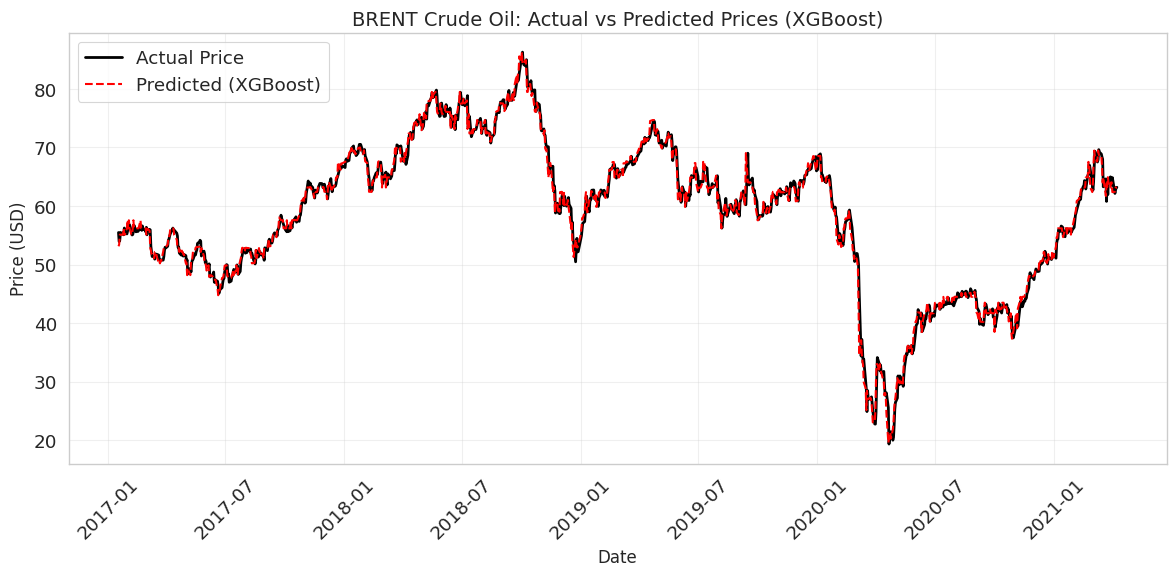


=== XGBoost Test Set Performance ===
RMSE: 1.3295
MAE : 0.9411
CSV file saved to: /content/drive/MyDrive/FYP PROJECT/BRENT_XGBoost_DataPredictions.csv


,Predicted_Price_LGBM
Date,
2017-01-17,53.116894
2017-01-18,53.411873
2017-01-19,55.111294
2017-01-20,55.111294
2017-01-23,55.111294


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 6) XGBoost Modelling with RandomizedSearchCV for Comparison

from sklearn.metrics import mean_squared_error, mean_absolute_error

lookback_xgb = X_train_scaled_bdf.shape[1]
param_dist_xgb = {
    'n_estimators': [100],
    'max_depth': [3],
    'learning_rate': [0.1],
}

tscv_xgb = TimeSeriesSplit(n_splits=5)
xgb_base = XGBRegressor(random_state=42, objective='reg:squarederror')

search_xgb = RandomizedSearchCV(
    estimator           = xgb_base,
    param_distributions = param_dist_xgb,
    n_iter              = 30,
    cv                  = tscv_xgb,
    scoring             = 'neg_root_mean_squared_error',
    random_state        = 42,
    n_jobs              = -1,
    verbose             = 1
)

def run_xgb_tscv(X_tr, y_tr, X_val, y_val, X_te, y_te):
    start = time.time()
    search_xgb.fit(X_tr, y_tr)
    print(f"XGBoost RandomizedSearchCV took {time.time() - start:.1f}s\n")

    best_xgb = search_xgb.best_estimator_

    val_preds = best_xgb.predict(X_val)
    rmse_val = sqrt(mean_squared_error(y_val, val_preds))
    mae_val = mean_absolute_error(y_val, val_preds)
    print("=== XGBoost Validation Set Performance ===")
    print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")


    preds    = best_xgb.predict(X_te)
    rmse_xgb = sqrt(mean_squared_error(y_te, preds))
    mae_xgb  = mean_absolute_error(y_te, preds)

    print(f"Number of lags (lookback): {lookback_xgb}")
    print("=== XGBoost Test Set Performance ===")
    print(f"RMSE: {rmse_xgb:.4f}, MAE: {mae_xgb:.4f}")
    print("Best XGBoost parameters:", search_xgb.best_params_,"\n")

    return search_xgb, best_xgb, val_preds

xgb_rand, best_xgb, y_val_pred_xgb   = run_xgb_tscv(X_train_scaled_bdf, y_btrain, X_val_scaled_bdf, y_bval, X_test_scaled_bdf, y_btest)

# =====================
# ACTUAL VS PREDICTED PLOT (XGBoost)
# =====================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error

if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Plotting might fail.")
    if 'X_test_scaled_bdf' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_bdf for plotting.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for plotting.")
else:
    test_index = y_btest.index

preds = best_xgb.predict(X_test_scaled_bdf)

y_bpred_array = np.asarray(preds)

plot_df = pd.DataFrame({
    'Actual': y_btest.values,
    'Predicted': y_bpred_array
}, index=test_index)


plt.figure(figsize=(12, 6))
plt.plot(plot_df.index, plot_df['Actual'],
         label='Actual Price', color='black', linewidth=2)
plt.plot(plot_df.index, plot_df['Predicted'],
         label='Predicted (XGBoost)', color='red', linestyle='--', linewidth=1.5)

plt.title('BRENT Crude Oil: Actual vs Predicted Prices (XGBoost)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

print("\n=== XGBoost Test Set Performance ===")
print(f"RMSE: {sqrt(mean_squared_error(y_btest, y_bpred_array)):.4f}")
print(f"MAE : {mean_absolute_error(y_btest, y_bpred_array):.4f}")

import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_btest, pd.Series) or not isinstance(y_btest.index, pd.DatetimeIndex):
    print("Warning: y_btest is not a pandas Series with DatetimeIndex. Cannot create plot_bdf.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_bdf, pd.DataFrame) and isinstance(X_test_scaled_bdf.index, pd.DatetimeIndex):
         test_index = X_test_scaled_bdf.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_btest.index

# Ensure y_pred is available as a numpy array or list
if 'preds' not in locals():
    raise ValueError("preds (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_bdf = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': preds
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_bdf = results_bdf.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/BRENT_XGBoost_DataPredictions.csv'

# Save the DataFrame to a CSV file
results_bdf.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_bdf.head())

**Reasoning**:
The error indicates that the data variables (X_train_scaled_df, y_train, X_val_scaled_df, y_val) are not defined in the current session. This is likely because the notebook state was reset or the cells defining these variables were not executed in the current environment. The `lgbm_objective` function relies on these variables being available in the global scope. The code to define these variables is present in cell `A0OmHNi74R50`. I will re-execute the cell that defines and prepares the data.



**Reasoning**:
The traceback indicates that the `wti_clean` DataFrame is not defined, which is required for the data preparation step. This means the cell that loads and cleans the WTI data (`hF3acd2KyWv_`) was not executed. I will re-execute the cell that loads and cleans the WTI data to ensure `wti_clean` is available.



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure wti_clean is available and has the 'Price' column
if 'wti_clean' not in locals() or 'Price' not in wti_clean.columns:
    print("Error: wti_clean DataFrame with 'Price' column is required.")
else:
    # Use the original wti_clean data for plotting the actual prices
    price_series = wti_clean['Price']

    # Get the indices (dates) for each split from the scaled dataframes
    if 'X_train_scaled_df' in locals() and 'X_val_scaled_df' in locals() and 'X_test_scaled_df' in locals():
        train_index = X_train_scaled_df.index
        val_index = X_val_scaled_df.index
        test_index = X_test_scaled_df.index

        plt.figure(figsize=(14, 6))

        # Plot the training set
        plt.plot(price_series.loc[train_index].index, price_series.loc[train_index].values, label='Training Set', color='blue')

        # Plot the validation set
        plt.plot(price_series.loc[val_index].index, price_series.loc[val_index].values, label='Validation Set', color='green')

        # Plot the test set
        plt.plot(price_series.loc[test_index].index, price_series.loc[test_index].values, label='Test Set', color='red')

        plt.title('WTI Crude Oil Price Time Series Split')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        print("Error: Scaled dataframes (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df) are required for plotting the split.")

Error: Scaled dataframes (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df) are required for plotting the split.


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure wti_clean is available and has the 'Price' column
if 'wti_clean' not in locals() or 'Price' not in wti_clean.columns:
    print("Error: wti_clean DataFrame with 'Price' column is required for plotting the split.")
else:
    # Use the original wti_clean data for plotting the actual prices
    price_series = wti_clean['Price']

    # Get the indices (dates) for each split from the scaled dataframes
    if 'X_train_scaled_df' in locals() and 'X_val_scaled_df' in locals() and 'X_test_scaled_df' in locals():
        train_index = X_train_scaled_df.index
        val_index = X_val_scaled_df.index
        test_index = X_test_scaled_df.index

        plt.figure(figsize=(14, 6))

        # Plot the training set
        plt.plot(price_series.loc[train_index].index, price_series.loc[train_index].values, label='Training Set', color='blue')

        # Plot the validation set
        plt.plot(price_series.loc[val_index].index, price_series.loc[val_index].values, label='Validation Set', color='green')

        # Plot the test set
        plt.plot(price_series.loc[test_index].index, price_series.loc[test_index].values, label='Test Set', color='red')

        plt.title('WTI Crude Oil Price Time Series Split Visualization')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    else:
        print("Error: Scaled dataframes (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df) are required for plotting the split visualization.")

Error: Scaled dataframes (X_train_scaled_df, X_val_scaled_df, X_test_scaled_df) are required for plotting the split visualization.


In [ ]:
import pandas as pd

# Ensure y_test is a pandas Series with a DatetimeIndex
if not isinstance(y_test, pd.Series) or not isinstance(y_test.index, pd.DatetimeIndex):
    print("Warning: y_test is not a pandas Series with DatetimeIndex. Cannot create plot_df.")
    # Attempt to use index from X_test_scaled_df if available
    if 'X_test_scaled_df' in locals() and isinstance(X_test_scaled_df, pd.DataFrame) and isinstance(X_test_scaled_df.index, pd.DatetimeIndex):
         test_index = X_test_scaled_df.index
         print("Using index from X_test_scaled_df for DataFrame.")
    else:
         raise TypeError("Could not find a suitable DatetimeIndex for creating the DataFrame.")
else:
    test_index = y_test.index

# Ensure y_pred is available as a numpy array or list
if 'y_pred' not in locals():
    raise ValueError("y_pred (predictions) are not available. Please run the PSO-LGBM prediction cell first.")

# Create a DataFrame with Actual and Predicted values using the correct index
results_df = pd.DataFrame({
    'Date': test_index,
    'Predicted_Price_LGBM': y_pred
})

# Set 'Date' as the index for better representation, though not strictly necessary for CSV export
results_df = results_df.set_index('Date')

# Define the path to save the CSV file
csv_path = '/content/drive/MyDrive/FYP PROJECT/WTI_PSO_LGBM_Predictions.csv'

# Save the DataFrame to a CSV file
results_df.to_csv(csv_path)

print(f"CSV file saved to: {csv_path}")
display(results_df.head())

CSV file saved to: /content/drive/MyDrive/FYP PROJECT/WTI_PSO_LGBM_Predictions.csv


,Actual_Price,Predicted_Price_LGBM
Date,,
2017-02-24,53.99,54.001712
2017-02-27,54.05,54.001712
2017-02-28,54.01,53.684151
2017-03-01,53.83,52.406973
2017-03-02,52.61,52.327674
